In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
import xgboost as xgb
import pickle as pkl
import importlib
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.tree import DecisionTreeClassifier as DTC
from xgboost.sklearn import XGBClassifier as XGBC
from sklearn.linear_model import LogisticRegression as LR
import scripts.xgboost_tuning as xgb_tuning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import log_loss, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score, accuracy_score
import matplotlib.pyplot as plt
from pylab import rcParams
import pyeeg
import pyrem as pruni
import scipy.signal as sig
import scipy.fftpack as fft
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from xgboost.sklearn import XGBRegressor as XGBR
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.ensemble import ExtraTreesRegressor as ETR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.svm import SVR
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from mne.decoding import CSP
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches


rcParams['figure.figsize'] = 5, 5
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
%matplotlib inline

In [2]:
def recurrence_plot(series, epsilon=0.001):
    rp = (np.abs(series - series[:, np.newaxis]) < epsilon).astype(int)
    plt.imshow(rp, origin='lower', interpolation='none', cmap='Greys')
    plt.show()


def poincare_plot(series):
    plt.scatter(series[:-1], series[1:])
    plt.show()

In [3]:
def normalized_crosscorrelation(series1, series2):
    if series1.shape[0] != series2.shape[0]:
        raise BaseException('shapes must be the same')
    if (series1.shape[0] == 1) or (series2.shape[0] == 1):
        if np.isclose(series1[0], 0.0, rtol=0.0, atol=0.000001) or np.isclose(series2[0], 0.0, rtol=0.0,
                                                                              atol=0.000001):
            return 0.0
        if np.isclose(series1[0], series2[0], rtol=0.0, atol=0.000001):
            return 1.0
        if np.isclose(abs(series1[0]), abs(series2[0]), rtol=0.0, atol=0.000001):
            return -1.0
        return 0.0
    return ((series1 - series1.mean()) * (series2 - series2.mean())).sum() /\
            (series1.shape[0] * series1.std() * series2.std())


def normalized_autocorrelation(series, max_lag=149):
    result = []
    result.append(normalized_crosscorrelation(series, series))
    if max_lag <= 0:
        return np.array(result)
    if max_lag >= series.shape[0]:
        raise BaseException('max_lag must be not more than series length')
    temp_series = np.hstack((series, series))
    for k in range(1, max_lag + 1):
        result.append(normalized_crosscorrelation(temp_series[:-k], temp_series[k:]))
    return np.array(result)

In [4]:
def recurrence(series, epsilon=0.001):
    return (np.abs(series - series[:, np.newaxis]) < epsilon).sum() / (series.shape[0] * series.shape[0])


def mean_autocorrelation(series, max_lag=149):
    return normalized_autocorrelation(series, max_lag).mean()


def mean_period(series, max_lag=149, threshold=-1.0):
    '''left local minimum and all local maximums must be uniquely defined'''
    if series.shape[0] < 3:
        raise BaseException('time series must be longer')
    auto_corr = normalized_autocorrelation(series, max_lag)
    auto_corr[auto_corr < threshold] = threshold
    diffs = np.diff(auto_corr)
    prod_diffs = diffs[:-1] * diffs[1:]
    susp_extr_dots = np.where(prod_diffs < 0)[0]
    start_index = np.array([0])
    if (diffs[susp_extr_dots[0]] < 0) and (diffs[susp_extr_dots[0] + 1] > 0):
        if susp_extr_dots.shape[0] > 1:
            start_index = np.hstack((0, susp_extr_dots[1::2], series.shape[0]))
    else:
        start_index = np.hstack((0, susp_extr_dots[::2], series.shape[0]))
    if start_index.shape[0] == 1:
        start_index = np.hstack((start_index, series.shape[0]))
    return np.diff(start_index).mean()


def poincare_SD(series):
    pp = np.hstack((series[:-1][:, np.newaxis], series[1:][:, np.newaxis]))
    p1 = np.array([[-1.0 / np.sqrt(2.0)], [1.0 / np.sqrt(2.0)]])
    p2 = np.array([[1.0 / np.sqrt(2.0)], [1.0 / np.sqrt(2.0)]])
    return np.dot(pp, p1).ravel().std(), np.dot(pp, p2).ravel().std()


def DET_and_mean_diag_length(series, epsilon=0.001, min_l=20):
    if (min_l > series.shape[0]) or (min_l < 1):
        raise BaseException('min_l must be in correct range')
    rp = (np.abs(series - series[:, np.newaxis]) < epsilon).astype(np.int)
    lines_hist = np.zeros(series.shape[0]).astype(np.int)
    isline = False
    length = 0
    for j in range(1, series.shape[0]):
        for k in range(series.shape[0] - j):
            if rp[k][j + k]:
                if isline:
                    length += 1
                else:
                    isline = True
                    length = 1
            else:
                isline = False
                if length:
                    lines_hist[length - 1] += 1
                    length = 0
        isline = False
        if length:
            lines_hist[length - 1] += 1
            length = 0
    lines_hist *= 2
    lines_hist[-1] += 1
    line_lengths = np.arange(series.shape[0]) + 1
    mask = line_lengths >= min_l
    line_lengths[~mask] = 0
    sum_length = (line_lengths * lines_hist).sum()
    return sum_length / rp.sum(), sum_length / lines_hist[mask].sum()

In [5]:
def FilterBank(X, filters='LowpassBank', sample_rate=500, butter_pows=None):
    freq_pairs = None
    X_processed = None
    if filters == 'LowpassBank':
        freq_pairs = [[0.5], [1], [2], [3], [4], [5], [7], [9], [15], [30]]
        butter_pows = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
    else:
        freq_pairs = filters
    for i in range(len(freq_pairs)):
        power = 5 if butter_pows is None else butter_pows[i]
        if len(freq_pairs[i]) == 1:
            b, a = sig.butter(power, 2 * freq_pairs[i][0] / sample_rate, btype='lowpass')
        else:
            b, a = sig.butter(power, 2 * np.array(freq_pairs[i]) / sample_rate, btype='bandpass')
        X_filtered = sig.lfilter(b, a, X, axis=0)
        X_processed = X_filtered if X_processed is None else np.c_[X_processed, X_filtered]
    return X_processed


def WindowDataset(dataset, interval=150, shift=1):
    if (interval < 1) or (interval > dataset.shape[0]):
        raise BaseException('interval has invalid value')
    if (shift < 1) or (shift > interval):
        raise BaseException('shift has invalid value')
    windowed_dataset = np.zeros((np.ceil((dataset.shape[0] - interval + 1) / shift).astype(np.int),
                                 interval, dataset.shape[1]))
    begin = 0
    for i in range(windowed_dataset.shape[0]):
        windowed_dataset[i] = dataset[begin: begin + interval, :].copy()
        begin += shift
    return windowed_dataset

In [6]:
def StackedRecurrence(X, epsilon=0.001):
    return np.sum(np.abs(X - X[:, np.newaxis]) < epsilon, axis=(0, 1)) / (X.shape[0] * X.shape[0])


def StackedDET(X, epsilon=0.001, min_l=20):
    result = np.zeros(2 * X.shape[1])
    for i in range(X.shape[1]):
        result[2 * i], result[2 * i + 1] = DET_and_mean_diag_length(series=X[:, i].ravel(),
                                                                    epsilon=epsilon, min_l=min_l)
    return result


def StackedPoincareSD(X):
    result = np.zeros(2 * X.shape[1])
    for i in range(X.shape[1]):
        result[2 * i], result[2 * i + 1] = poincare_SD(series=X[:, i].ravel())
    return result


def StackedMeanAutocorrelation(X, max_lag=149):
    result = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        result[i] = mean_autocorrelation(series=X[:, i].ravel(), max_lag=max_lag)
    return result


def StackedMeanPeriod(X, max_lag=149, threshold=-1.0):
    result = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        result[i] = mean_period(series=X[:, i].ravel(), max_lag=max_lag, threshold=threshold)
    return result


def StackedAproximateEntropy(X, M=None, R=None):
    if M is None:
        M = 19 + np.ones(X.shape[1]).astype(np.int)
    if R is None:
        R = 0.001 + np.zeros(X.shape[1])
    result = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        result[i] = pyeeg.ap_entropy(X=X[:, i].ravel(), M=M[i], R=R[i])
    return result


def StackedSampleEntropy(X, M=None, R=None):
    if M is None:
        M = 19 + np.ones(X.shape[1]).astype(np.int)
    if R is None:
        R = 0.001 + np.zeros(X.shape[1])
    result = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        result[i] = pyeeg.samp_entropy(X=X[:, i].ravel(), M=M[i], R=R[i])
    return result


def StackedSpectralEntropy(X, sampling_freq=500):
    result = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        result[i] = pruni.spectral_entropy(a=X[:, i].ravel(), sampling_freq=sampling_freq)
    return result


def StackedPFD(X):
    result = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        result[i] = pruni.pfd(a=X[:, i].ravel())
    return result


def StackedHjorth(X):
    result = np.zeros(3 * X.shape[1])
    for i in range(X.shape[1]):
        result[3 * i], result[3 * i + 1], result[3 * i + 2] = pruni.hjorth(X[:, i].ravel())
    return result

In [7]:
def TransformWindowedDataset(X_windowed, Y_windowed, parameters=None):
    if parameters is None:
        parameters = {'FilterBank': {'filters': [[0.5], [1], [2], [3], [4], [5], [7], [9], [15], [30]],
                                     'sample_rate': 500, 'butter_pows': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]},
                      'StackedRecurrence': {'epsilon': 0.001},
                      'StackedDET': None,#{'epsilon': 0.001, 'min_l': 20},
                      'StackedPoincareSD': True,
                      'StackedMeanAutocorrelation': None,#{'max_lag': 149},
                      'StackedMeanPeriod': None,#{'max_lag': 149, 'threshold': -1.0},
                      'StackedAproximateEntropy': None,#{'M': None, 'R': None},
                      'StackedSampleEntropy': None,#{'M': None, 'R': None},
                      'StackedSpectralEntropy': {'sampling_freq': 500},
                      'StackedPFD': None,#True,
                      'StackedHjorth': True,
                      'FFT': {'sampling_freq': 500},
                      'TargetWrite': 2}#4 -- begin of the window, 2 -- middle of the window, 1 -- end of the window
    features_num = X_windowed.shape[2]
    if parameters['FilterBank'] is not None:
        features_num *= len(parameters['FilterBank']['filters'])
    multiplier = 0
    if parameters['StackedRecurrence'] is not None:
        multiplier += 1
    if parameters['StackedDET'] is not None:
        multiplier += 2
    if parameters['StackedPoincareSD'] is not None:
        multiplier += 2
    if parameters['StackedMeanAutocorrelation'] is not None:
        multiplier += 1
    if parameters['StackedMeanPeriod'] is not None:
        multiplier += 1
    if parameters['StackedAproximateEntropy'] is not None:
        multiplier += 1
    if parameters['StackedSampleEntropy'] is not None:
        multiplier += 1
    if parameters['StackedSpectralEntropy'] is not None:
        multiplier += 1
    if parameters['StackedPFD'] is not None:
        multiplier += 1
    if parameters['StackedHjorth'] is not None:
        multiplier += 3
    features_num *= multiplier
    if parameters['FFT'] is not None:
        features_num += X_windowed.shape[2] * X_windowed.shape[1]
    if features_num == 0:
        raise BaseException('specify features')
    X_transformed = np.zeros((X_windowed.shape[0], features_num))
    Y_transformed = np.zeros((Y_windowed.shape[0], Y_windowed.shape[2])).astype(np.int)
    X_banded = None
    if parameters['FilterBank'] is not None:
        X_banded = np.zeros((X_windowed.shape[0], X_windowed.shape[1],
                             X_windowed.shape[2] * len(parameters['FilterBank']['filters'])))
        for i in range(X_windowed.shape[0]):
            X_banded[i] = FilterBank(X=X_windowed[i], filters=parameters['FilterBank']['filters'],
                                     sample_rate=parameters['FilterBank']['sample_rate'],
                                     butter_pows=parameters['FilterBank']['butter_pows'])
    else:
        X_banded = X_windowed
    print('    banded dataset')
    for i in range(X_banded.shape[0]):
        step = 0
        if parameters['StackedRecurrence'] is not None:
            X_transformed[i, step: step + X_banded.shape[2]] = StackedRecurrence(X=X_banded[i],
                                                               epsilon=parameters['StackedRecurrence']['epsilon'])
            step += X_banded.shape[2]
        if parameters['StackedDET'] is not None:
            X_transformed[i, step: step + 2 * X_banded.shape[2]] = StackedDET(X=X_banded[i],
                                                                   epsilon=parameters['StackedDET']['epsilon'],
                                                                   min_l=parameters['StackedDET']['min_l'])
            step += 2 * X_banded.shape[2]
        if parameters['StackedPoincareSD'] is not None:
            X_transformed[i, step: step + 2 * X_banded.shape[2]] = StackedPoincareSD(X=X_banded[i])
            step += 2 * X_banded.shape[2]
        if parameters['StackedMeanAutocorrelation'] is not None:
            X_transformed[i, step: step + X_banded.shape[2]] = StackedMeanAutocorrelation(X=X_banded[i],
                                                        max_lag=parameters['StackedMeanAutocorrelation']['max_lag'])
            step += X_banded.shape[2]
        if parameters['StackedMeanPeriod'] is not None:
            X_transformed[i, step: step + X_banded.shape[2]] = StackedMeanPeriod(X=X_banded[i],
                                                               max_lag=parameters['StackedMeanPeriod']['max_lag'],
                                                             threshold=parameters['StackedMeanPeriod']['threshold'])
            step += X_banded.shape[2]
        if parameters['StackedAproximateEntropy'] is not None:
            X_transformed[i, step: step + X_banded.shape[2]] = StackedAproximateEntropy(X=X_banded[i],
                                                               M=parameters['StackedAproximateEntropy']['M'],
                                                               R=parameters['StackedAproximateEntropy']['R'])
            step += X_banded.shape[2]
        if parameters['StackedSampleEntropy'] is not None:
            X_transformed[i, step: step + X_banded.shape[2]] = StackedSampleEntropy(X=X_banded[i],
                                                               M=parameters['StackedSampleEntropy']['M'],
                                                               R=parameters['StackedSampleEntropy']['R'])
            step += X_banded.shape[2]
        if parameters['StackedSpectralEntropy'] is not None:
            X_transformed[i, step: step + X_banded.shape[2]] = StackedSpectralEntropy(X=X_banded[i],
                                                sampling_freq=parameters['StackedSpectralEntropy']['sampling_freq'])
            step += X_banded.shape[2]
        if parameters['StackedPFD'] is not None:
            X_transformed[i, step: step + X_banded.shape[2]] = StackedPFD(X=X_banded[i])
            step += X_banded.shape[2]
        if parameters['StackedHjorth'] is not None:
            X_transformed[i, step: step + 3 * X_banded.shape[2]] = StackedHjorth(X=X_banded[i])
            step += 3 * X_banded.shape[2]
        if parameters['FFT'] is not None:
            X_transformed[i, step: step + X_windowed.shape[2] * X_windowed.shape[1]] = fft.rfft(
                                                                                    x=X_windowed[i], axis=0).ravel()
            step += X_windowed.shape[2] * X_windowed.shape[1]
        #print('    step %i completed'%(i))
    print('    transformed design matrix')
    for i in range(Y_windowed.shape[0]):
        if parameters['TargetWrite'] == 4:
            Y_transformed[i] = Y_windowed[i, 0, :]
        elif parameters['TargetWrite'] == 1:
            Y_transformed[i] = Y_windowed[i, -1, :]
        else:
            Y_transformed[i] = Y_windowed[i, Y_windowed.shape[1] // 2, :]
    print('    transformed target matrix')
    return X_transformed, Y_transformed

In [8]:
def CSPWindowDataset(dataset, interval=150, shift=1):
    if (interval < 1) or (interval > dataset.shape[0]):
        raise BaseException('interval has invalid value')
    if (shift < 1) or (shift > interval):
        raise BaseException('shift has invalid value')
    windowed_dataset = np.zeros((np.ceil((dataset.shape[0] - interval + 1) / shift).astype(np.int),
                                 dataset.shape[1], interval))
    begin = 0
    for i in range(windowed_dataset.shape[0]):
        windowed_dataset[i] = dataset[begin: begin + interval, :].copy().T
        begin += shift
    return windowed_dataset


def TransformCSPWindowedDataset(X_windowed):
    X_transformed = np.zeros((X_windowed.shape[0], (7 + X_windowed.shape[2]) * X_windowed.shape[1]))
    for i in range(X_transformed.shape[0]):
        X_transformed[i, :X_windowed.shape[1]] = StackedRecurrence(X_windowed[i, :, :].T, epsilon=0.000004)
        X_transformed[i, X_windowed.shape[1]: 3 * X_windowed.shape[1]] = StackedPoincareSD(X_windowed[i, :, :].T)
        X_transformed[i, 3 * X_windowed.shape[1]: 6 * X_windowed.shape[1]] = StackedHjorth(X_windowed[i, :, :].T)
        X_transformed[i, 6 * X_windowed.shape[1]: 7 * X_windowed.shape[1]] = StackedSpectralEntropy(
            X_windowed[i, :, :].T)
        X_transformed[i, 7 * X_windowed.shape[1]: (7 + X_windowed.shape[2]) * X_windowed.shape[1]] = fft.rfft(
            X_windowed[i, :, :], axis=1).ravel()
    return X_transformed

In [9]:
b, a = sig.butter(5, 2 * np.array([1.0, 35]) / 500, btype='bandpass')
file = open('./grouped_subjs/subj1_train_data.pkl', 'rb')
dataset_np = sig.lfilter(b, a, 1e-6 * pkl.load(file), axis=0)
file.close()
dataset_np -= dataset_np.mean(axis=0)
file = open('./grouped_subjs/subj1_train_events.pkl', 'rb')
target_np = pkl.load(file)
file.close()

dataset_np = CSPWindowDataset(dataset=dataset_np, interval=150, shift=75)
target_np = WindowDataset(dataset=target_np, interval=150, shift=75)
target_matrix = np.zeros((target_np.shape[0], target_np.shape[2])).astype(np.int)
for i in range(target_matrix.shape[0]):
    target_matrix[i, :] = target_np[i, target_np.shape[1] // 2, :].astype(np.int)
target_np = None

cv = KFold(n_splits=3, shuffle=True, random_state=317)

In [ ]:
algorithms = [(SVC(probability=True), 'Support Vector Machine'),
              (LR(), 'Logistic Regression'),
              (KNC(), 'k Nearest Neighbors'),
              (DTC(), 'Decision Tree'),
              (RFC(), 'Random Forest'),
              (ETC(), 'Extra Trees'),
              (ABC(), 'Ada Boost'),
              (XGBC(), 'Extreme Gradient Boosting'),
              (LDA(), 'Linear Discriminant Analysis'),
              (QDA(), 'Quadratic Discriminant Analysis'),
              (SVR(), 'Support Vector Machine (Regressor)'),
              (KNR(), 'k Nearest Neighbors (Regressor)'),
              (DTR(), 'Decision Tree (Regressor)'),
              (RFR(), 'Random Forest (Regressor)'),
              (ETR(), 'Extra Trees (Regressor)'),
              (ABR(), 'Ada Boost (Regressor)'),
              (XGBR(), 'Extreme Gradient Boosting (Regressor)')]
csp_space = CSP(n_components=dataset_np.shape[1], reg='oas', transform_into='csp_space')
csp = CSP(n_components=dataset_np.shape[1], reg='oas')
scaler = StandardScaler()
scaler_pow = StandardScaler()
transformer = PCA(n_components=0.95, svd_solver='full')
for alg, name in algorithms:
    print('Started algorithm:', name)
    local_scores = []
    for i in range(target_matrix.shape[1]):
        print('    started task %i'%(i + 1))
        scores = []
        j = 1
        for train_idxs, test_idxs in cv.split(target_matrix[:, i]):
            print('        started fold %i'%(j))
            j += 1
            print('            started train transformation')
            train_matrix = scaler_pow.fit_transform(np.hstack((transformer.fit_transform(scaler.fit_transform(
                TransformCSPWindowedDataset(csp_space.fit_transform(X=dataset_np[train_idxs],
                                                                    y=target_matrix[train_idxs, i])))),
                                                               csp.fit_transform(X=dataset_np[train_idxs],
                                                                                 y=target_matrix[train_idxs, i]))))
            print('            started test transformation')
            test_matrix = scaler_pow.transform(np.hstack((transformer.transform(scaler.transform(
                TransformCSPWindowedDataset(csp_space.transform(X=dataset_np[test_idxs])))),
                                                          csp.transform(X=dataset_np[test_idxs]))))
            print('            started training')
            alg.fit(train_matrix, target_matrix[train_idxs, i])
            print('            started estimation')
            if '(Regressor)' not in name:
                scores.append(roc_auc_score(y_score=alg.predict_proba(test_matrix)[:, 1].ravel(),
                                            y_true=target_matrix[test_idxs, i]))
            else:
                scores.append(roc_auc_score(y_score=alg.predict(test_matrix), y_true=target_matrix[test_idxs, i]))
        local_scores.append(np.mean(scores))
    print('                Pipeline cross validation completed:', name, 'algorithm')
    print('                    mean roc auc is:', np.mean(local_scores))

Started algorithm: Support Vector Machine
    started task 1
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 2
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformat

            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 5
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 6
        started fold 1
            started train transformation
            started test transformation
       

            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 2
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 3
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started

            started training
            started estimation
    started task 5
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 6
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            starte

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 2
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 3
        started fold 1
            started train transformation
            started test transformation
       

            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 5
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 6
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
       

            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 2
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 3
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            starte

Testing features on benchmark classifiers

In [9]:
b, a = sig.butter(5, 2 * np.array([1.0, 35]) / 500, btype='bandpass')
dataset_np = sig.lfilter(b, a, 1e-6 * pd.read_csv('./subjectedtrain/subj1_series2_data.csv', sep=',',
                                                  index_col='id').as_matrix(), axis=0)
dataset_mean = dataset_np.mean(axis=0)
dataset_np -= dataset_mean
dataset_test = sig.lfilter(b, a, 1e-6 * pd.read_csv('./subjectedtrain/subj1_series1_data.csv', sep=',',
                                                  index_col='id').as_matrix(), axis=0)
dataset_test -= dataset_mean
target_np = pd.read_csv('./subjectedtrain/subj1_series2_events.csv', sep=',', index_col='id').as_matrix()
target_test = pd.read_csv('./subjectedtrain/subj1_series1_events.csv', sep=',', index_col='id').as_matrix()

dataset_np = CSPWindowDataset(dataset=dataset_np, interval=150, shift=75)
dataset_test = CSPWindowDataset(dataset=dataset_test, interval=150, shift=75)
target_np = WindowDataset(dataset=target_np, interval=150, shift=75)
target_test = WindowDataset(dataset=target_test, interval=150, shift=75)
target_matrix = np.zeros((target_np.shape[0], target_np.shape[2])).astype(np.int)
target_test_matrix = np.zeros((target_test.shape[0], target_test.shape[2])).astype(np.int)
for i in range(target_matrix.shape[0]):
    target_matrix[i, :] = target_np[i, target_np.shape[1] // 2, :].astype(np.int)
target_np = None
for i in range(target_test_matrix.shape[0]):
    target_test_matrix[i, :] = target_test[i, target_test.shape[1] // 2, :].astype(np.int)
target_test = None

cv = KFold(n_splits=3, shuffle=True, random_state=317)

In [10]:
dataset_np.shape, target_matrix.shape, dataset_test.shape, target_test_matrix.shape

((3625, 32, 150), (3625, 6), (1592, 32, 150), (1592, 6))

In [9]:
#For cross-val version of tuning
file = open('./grouped_subjs/subj1_train_data.pkl', 'rb')
b, a = sig.butter(5, 2 * np.array([1.0, 35]) / 500, btype='bandpass')
dataset_np = sig.lfilter(b, a, 1e-6*pkl.load(file), axis=0)
dataset_np -= dataset_np.mean(axis=0)
file.close()
file = open('./grouped_subjs/subj1_train_events.pkl', 'rb')
target_np = pkl.load(file)
file.close()
train_windowed = CSPWindowDataset(dataset=dataset_np, interval=150, shift=75)
target_windowed = WindowDataset(dataset=target_np, interval=150, shift=75)
target_matrix = np.zeros((target_windowed.shape[0], target_windowed.shape[2])).astype(np.int)
for i in range(target_matrix.shape[0]):
    target_matrix[i, :] = target_windowed[i, target_windowed.shape[1] // 2, :].astype(np.int)
target_windowed = None
cv = KFold(n_splits=3, shuffle=True, random_state=317)
train_windowed.shape, target_matrix.shape

((15805, 32, 150), (15805, 6))

In [9]:
#For hold-out version of tuning
#train on first and test on second
b, a = sig.butter(5, 2 * np.array([1.0, 35]) / 500, btype='bandpass')

file = open('./grouped_subjs/subj1_train_data.pkl', 'rb')
dataset_np = sig.lfilter(b, a, 1e-6 * pkl.load(file), axis=0)
file.close()

dataset_mean = dataset_np.mean(axis=0)
dataset_np -= dataset_mean

file = open('./grouped_subjs/subj2_train_data.pkl', 'rb')
dataset_test = sig.lfilter(b, a, 1e-6 * pkl.load(file), axis=0)
file.close()

dataset_test -= dataset_mean

file = open('./grouped_subjs/subj1_train_events.pkl', 'rb')
target_np = pkl.load(file)
file.close()
file = open('./grouped_subjs/subj2_train_events.pkl', 'rb')
target_test = pkl.load(file)
file.close()

dataset_np = CSPWindowDataset(dataset=dataset_np, interval=150, shift=75)
dataset_test = CSPWindowDataset(dataset=dataset_test, interval=150, shift=75)

target_np = WindowDataset(dataset=target_np, interval=150, shift=75)
target_test = WindowDataset(dataset=target_test, interval=150, shift=75)

target_matrix = np.zeros((target_np.shape[0], target_np.shape[2])).astype(np.int)
target_test_matrix = np.zeros((target_test.shape[0], target_test.shape[2])).astype(np.int)
for i in range(target_matrix.shape[0]):
    target_matrix[i, :] = target_np[i, target_np.shape[1] // 2, :].astype(np.int)
target_np = None
for i in range(target_test_matrix.shape[0]):
    target_test_matrix[i, :] = target_test[i, target_test.shape[1] // 2, :].astype(np.int)
target_test = None

cv = KFold(n_splits=3, shuffle=True, random_state=317)
dataset_np.shape, target_matrix.shape, dataset_test.shape, target_test_matrix.shape

((15805, 32, 150), (15805, 6), (18808, 32, 150), (18808, 6))

In [12]:
algorithms = [(SVC(probability=True), 'Support Vector Machine'),
              (LR(), 'Logistic Regression'),
              (ABC(), 'Ada Boost'),
              (XGBC(), 'Extreme Gradient Boosting'),
              (LDA(), 'Linear Discriminant Analysis')]
csp_space = CSP(n_components=dataset_np.shape[1], reg='oas', transform_into='csp_space')
csp = CSP(n_components=dataset_np.shape[1], reg='oas')
scaler = StandardScaler()
scaler_pow = StandardScaler()
transformer = PCA(n_components=0.80, svd_solver='full')
pr_local_scores = []
rc_local_scores = []
f1_local_scores = []
ap_local_scores = []
ac_local_scores = []
au_local_scores = []
for alg, name in algorithms:
    print('Started algorithm:', name)
    pr_scores = []
    rc_scores = []
    f1_scores = []
    ap_scores = []
    ac_scores = []
    au_scores = []
    for i in range(target_matrix.shape[1]):
        print('    started task %i'%(i + 1))
        print('         started train transformation')
        train_matrix = scaler_pow.fit_transform(np.hstack((transformer.fit_transform(scaler.fit_transform(
            TransformCSPWindowedDataset(csp_space.fit_transform(X=dataset_np,
                                                                y=target_matrix[:, i])))),
                                                            csp.fit_transform(X=dataset_np,
                                                                                y=target_matrix[:, i]))))
        print('         started test transformation')
        test_matrix = scaler_pow.transform(np.hstack((transformer.transform(scaler.transform(
            TransformCSPWindowedDataset(csp_space.transform(X=dataset_test)))),
                                                        csp.transform(X=dataset_test))))
        print('         started training')
        alg.fit(train_matrix, target_matrix[:, i])
        print('         started estimation')
        pred_score = alg.predict_proba(test_matrix)[:, 1].ravel()
        pred_label = alg.predict(test_matrix)
        pr_scores.append(precision_score(y_true=target_test_matrix[:, i].ravel(), y_pred=pred_label))
        rc_scores.append(recall_score(y_true=target_test_matrix[:, i].ravel(), y_pred=pred_label))
        f1_scores.append(f1_score(y_true=target_test_matrix[:, i].ravel(), y_pred=pred_label))
        ap_scores.append(average_precision_score(y_true=target_test_matrix[:, i].ravel(),
                                                    y_score=pred_score))
        ac_scores.append(accuracy_score(y_true=target_test_matrix[:, i].ravel(), y_pred=pred_label))
        au_scores.append(roc_auc_score(y_true=target_test_matrix[:, i].ravel(), y_score=pred_score))
    pr_local_scores.append(pr_scores)
    rc_local_scores.append(rc_scores)
    f1_local_scores.append(f1_scores)
    ap_local_scores.append(ap_scores)
    ac_local_scores.append(ac_scores)
    au_local_scores.append(au_scores)
    print('    Pipeline cross validation completed:', name, 'algorithm')
    print('        mean precision is:', np.mean(pr_local_scores[-1]))
    print('        mean recall is:', np.mean(rc_local_scores[-1]))
    print('        mean f1 measure is:', np.mean(f1_local_scores[-1]))
    print('        mean average precision is:', np.mean(ap_local_scores[-1]))
    print('        mean accuracy is:', np.mean(ac_local_scores[-1]))
    print('        mean auc roc is:', np.mean(au_local_scores[-1]))
val_results = (('order',
                ('Support Vector Machine',
                 'Logistic Regression',
                 'Ada Boost',
                 'Extreme Gradient Boosting',
                 'Linear Discriminant Analysis')),
               ('precision', pr_local_scores),
               ('recall', rc_local_scores),
               ('f1 measure', f1_local_scores),
               ('average precision', ap_local_scores),
               ('accuracy', ac_local_scores),
               ('auc roc', au_local_scores))
file = open('current_solution.pkl', 'wb')
pkl.dump(val_results, file)
file.close()

Started algorithm: Support Vector Machine
    started task 1
         started train transformation
         started test transformation
         started training
         started estimation
    started task 2
         started train transformation
         started test transformation
         started training
         started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


    started task 3
         started train transformation
         started test transformation
         started training
         started estimation
    started task 4
         started train transformation
         started test transformation
         started training
         started estimation
    started task 5
         started train transformation
         started test transformation
         started training
         started estimation
    started task 6
         started train transformation
         started test transformation
         started training
         started estimation
    Pipeline cross validation completed: Support Vector Machine algorithm
        mean precision is: 0.0
        mean recall is: 0.0
        mean f1 measure is: 0.0
        mean average precision is: 0.027421797845
        mean accuracy is: 0.979565433149
        mean auc roc is: 0.4760372331
Started algorithm: Logistic Regression
    started task 1
         started train transformation
         started t

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


         started test transformation
         started training
         started estimation
    started task 4
         started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


         started test transformation
         started training
         started estimation
    started task 5
         started train transformation
         started test transformation
         started training
         started estimation
    started task 6
         started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


         started test transformation
         started training
         started estimation
    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
        mean precision is: 0.0
        mean recall is: 0.0
        mean f1 measure is: 0.0
        mean average precision is: 0.027333289
        mean accuracy is: 0.979352757692
        mean auc roc is: 0.577600086466
Started algorithm: Linear Discriminant Analysis
    started task 1
         started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


         started test transformation
         started training
         started estimation
    started task 2
         started train transformation
         started test transformation
         started training
         started estimation
    started task 3
         started train transformation
         started test transformation
         started training
         started estimation
    started task 4
         started train transformation
         started test transformation
         started training
         started estimation
    started task 5
         started train transformation
         started test transformation
         started training
         started estimation
    started task 6
         started train transformation
         started test transformation
         started training
         started estimation
    Pipeline cross validation completed: Linear Discriminant Analysis algorithm
        mean precision is: 0.0248276179582
        mean recall is: 0.0659722222222
      

Started test with fraction 0.99
    Started algorithm: Logistic Regression
        started task 1
            started fold 1
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 2
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 3
                started train transformation
                started test transformation
                started training
                started estimation
        started task 2
            started fold 1
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 2
                started train transformation
                started test transformation
                started tra

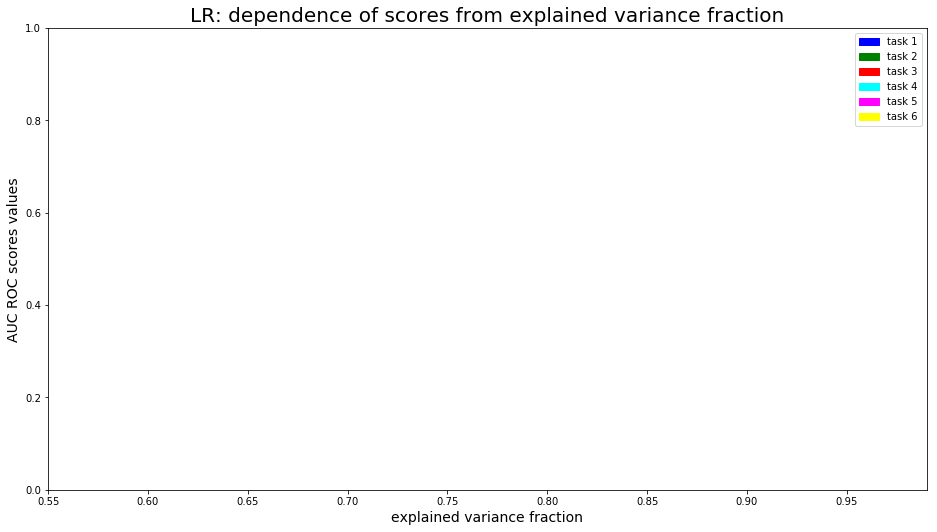

In [10]:
#LR Solution tuning cross-validation version
algorithms = [(LR(), 'Logistic Regression')]
csp_space = CSP(n_components=dataset_np.shape[1], reg='oas', transform_into='csp_space')
csp = CSP(n_components=dataset_np.shape[1], reg='oas')
scaler = StandardScaler()
scaler_pow = StandardScaler()
fracs = np.array([0.99])#np.array([0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99])
au_algorithm_scores = []
for frac in fracs:
    print('Started test with fraction', frac)
    transformer = PCA(n_components=frac, svd_solver='full')
    for alg, name in algorithms:
        print('    Started algorithm:', name)
        au_local_scores = []
        for i in range(target_matrix.shape[1]):
            print('        started task %i'%(i + 1))
            au_scores = []
            j = 1
            for train_idxs, test_idxs in cv.split(target_matrix[:, i]):
                print('            started fold %i'%(j))
                j += 1
                print('                started train transformation')
                train_matrix = scaler_pow.fit_transform(
                                   transformer.fit_transform(
                                       scaler.fit_transform(
                                           np.hstack((
                                               TransformCSPWindowedDataset(
                                                   csp_space.fit_transform(X=train_windowed[train_idxs],
                                                                           y=target_matrix[train_idxs, i])),
                                               csp.fit_transform(X=train_windowed[train_idxs],
                                                                 y=target_matrix[train_idxs, i]))))))
                print('                started test transformation')
                test_matrix = scaler_pow.transform(
                                  transformer.transform(
                                      scaler.transform(
                                          np.hstack((
                                              TransformCSPWindowedDataset(
                                                  csp_space.transform(X=train_windowed[test_idxs])),
                                              csp.transform(X=train_windowed[test_idxs]))))))
                print('                started training')
                alg.fit(train_matrix, target_matrix[train_idxs, i])
                print('                started estimation')
                pred_score = alg.predict_proba(test_matrix)[:, 1].ravel()
                au_scores.append(roc_auc_score(y_true=target_matrix[test_idxs, i].ravel(), y_score=pred_score))
            au_local_scores.append(np.mean(au_scores))
        au_algorithm_scores.append(au_local_scores)
        print('                    Pipeline cross validation completed:', name, 'algorithm')
        print('                        mean auc roc is:', au_algorithm_scores[-1])
    print(au_algorithm_scores)
pca_tuning_scores = (('fractions', fracs), (('auc roc', np.array(au_algorithm_scores))))
file = open('LR_Solution_tuning_results.pkl', 'wb')
pkl.dump(pca_tuning_scores, file)
file.close()

fig = plt.figure(figsize=(10, 8.5))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.57, right=1.79, wspace=0.0, hspace=0.0)

blue_patch = mpatches.Patch(color='blue', label='task 1')
green_patch = mpatches.Patch(color='green', label='task 2')
red_patch = mpatches.Patch(color='red', label='task 3')
cyan_patch = mpatches.Patch(color='cyan', label='task 4')
magneta_patch = mpatches.Patch(color='magenta', label='task 5')
yellow_patch = mpatches.Patch(color='yellow', label='task 6')

ax = plt.subplot(gs[0])
ax.legend(handles=[blue_patch, green_patch, red_patch, cyan_patch, magneta_patch, yellow_patch])

ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 0], color='blue')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 1], color='green')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 2], color='red')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 3], color='cyan')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 4], color='magenta')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 5], color='yellow')

ax.set_xlim([0.55, 0.99])
ax.set_ylim([0.0, 1.0])
plt.title('LR: dependence of scores from explained variance fraction', fontsize=20)
plt.xlabel('explained variance fraction', fontsize=14)
plt.ylabel('AUC ROC scores values', fontsize=14)

In [10]:
#Solution testing cross-validation version
algorithms = [(SVC(probability=True), 'Support Vector Machine'),
              (LR(), 'Logistic Regression'),
              (ABC(), 'Ada Boost'),
              (XGBC(), 'Extreme Gradient Boosting'),
              (LDA(), 'Linear Discriminant Analysis')]
csp_space = CSP(n_components=dataset_np.shape[1], reg='oas', transform_into='csp_space')
csp = CSP(n_components=dataset_np.shape[1], reg='oas')
scaler = StandardScaler()
scaler_pow = StandardScaler()
transformer = PCA(n_components=0.8, svd_solver='full')
au_algorithm_scores = []
for alg, name in algorithms:
    print('Started algorithm:', name)
    au_local_scores = []
    for i in range(target_matrix.shape[1]):
        print('    started task %i'%(i + 1))
        au_scores = []
        j = 1
        for train_idxs, test_idxs in cv.split(target_matrix[:, i]):
            print('        started fold %i'%(j))
            j += 1
            print('            started train transformation')
            train_matrix = scaler_pow.fit_transform(
                               transformer.fit_transform(
                                   scaler.fit_transform(
                                       np.hstack((
                                            TransformCSPWindowedDataset(
                                               csp_space.fit_transform(X=train_windowed[train_idxs],
                                                                       y=target_matrix[train_idxs, i])),
                                           csp.fit_transform(X=train_windowed[train_idxs],
                                                             y=target_matrix[train_idxs, i]))))))
            print('            started test transformation')
            test_matrix = scaler_pow.transform(
                              transformer.transform(
                                  scaler.transform(
                                        np.hstack((
                                          TransformCSPWindowedDataset(
                                              csp_space.transform(X=train_windowed[test_idxs])),
                                          csp.transform(X=train_windowed[test_idxs]))))))
            print('            started training')
            alg.fit(train_matrix, target_matrix[train_idxs, i])
            print('            started estimation')
            pred_score = alg.predict_proba(test_matrix)[:, 1].ravel()
            au_scores.append(roc_auc_score(y_true=target_matrix[test_idxs, i].ravel(), y_score=pred_score))
        au_local_scores.append(np.mean(au_scores))
    au_algorithm_scores.append(au_local_scores)
    print('                Pipeline cross validation completed:', name, 'algorithm')
    print('                    mean auc roc is:', au_algorithm_scores[-1])
    print(au_algorithm_scores)
    pca_tuning_scores = (('order', ('Support Vector Machine',
                                    'Logistic Regression',
                                    'Ada Boost',
                                    'Extreme Gradient Boosting',
                                    'Linear Discriminant Analysis')),
                         (('auc roc', np.array(au_algorithm_scores))))
file = open('Solution_testing_results.pkl', 'wb')
pkl.dump(pca_tuning_scores, file)
file.close()

Started algorithm: Support Vector Machine
    started task 1
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 2
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformat

            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 4
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 5
        started fold 1
            started

            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 5
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 6
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started

Current soution

In [27]:
algorithms = [(SVC(probability=True), 'Support Vector Machine'),
              (LR(), 'Logistic Regression'),
              (KNC(), 'k Nearest Neighbors'),
              (DTC(), 'Decision Tree'),
              (RFC(), 'Random Forest'),
              (ETC(), 'Extra Trees'),
              (ABC(), 'Ada Boost'),
              (XGBC(), 'Extreme Gradient Boosting'),
              (LDA(), 'Linear Discriminant Analysis'),
              (QDA(), 'Quadratic Discriminant Analysis')]
csp_space = CSP(n_components=dataset_np.shape[1], reg='oas', transform_into='csp_space')
csp = CSP(n_components=dataset_np.shape[1], reg='oas')
scaler = StandardScaler()
scaler_pow = StandardScaler()
transformer = PCA(n_components=0.95, svd_solver='full')
for alg, name in algorithms:
    print('Started algorithm:', name)
    pr_local_scores = []
    rc_local_scores = []
    f1_local_scores = []
    ap_local_scores = []
    ac_local_scores = []
    au_local_scores = []
    for i in range(target_matrix.shape[1]):
        print('    started task %i'%(i + 1))
        pr_scores = []
        rc_scores = []
        f1_scores = []
        ap_scores = []
        ac_scores = []
        au_scores = []
        j = 1
        for train_idxs, test_idxs in cv.split(target_matrix[:, i]):
            print('        started fold %i'%(j))
            j += 1
            print('            started train transformation')
            train_matrix = scaler_pow.fit_transform(np.hstack((transformer.fit_transform(scaler.fit_transform(
                TransformCSPWindowedDataset(csp_space.fit_transform(X=dataset_np[train_idxs],
                                                                    y=target_matrix[train_idxs, i])))),
                                                               csp.fit_transform(X=dataset_np[train_idxs],
                                                                                 y=target_matrix[train_idxs, i]))))
            print('            started test transformation')
            test_matrix = scaler_pow.transform(np.hstack((transformer.transform(scaler.transform(
                TransformCSPWindowedDataset(csp_space.transform(X=dataset_np[test_idxs])))),
                                                          csp.transform(X=dataset_np[test_idxs]))))
            print('            started training')
            alg.fit(train_matrix, target_matrix[train_idxs, i])
            print('            started estimation')
            pred_score = alg.predict_proba(test_matrix)[:, 1].ravel()
            pred_label = alg.predict(test_matrix)
            pr_scores.append(precision_score(y_true=target_matrix[test_idxs, i].ravel(), y_pred=pred_label))
            rc_scores.append(recall_score(y_true=target_matrix[test_idxs, i].ravel(), y_pred=pred_label))
            f1_scores.append(f1_score(y_true=target_matrix[test_idxs, i].ravel(), y_pred=pred_label))
            ap_scores.append(average_precision_score(y_true=target_matrix[test_idxs, i].ravel(),
                                                     y_score=pred_score))
            ac_scores.append(accuracy_score(y_true=target_matrix[test_idxs, i].ravel(), y_pred=pred_label))
            au_scores.append(roc_auc_score(y_true=target_matrix[test_idxs, i].ravel(), y_score=pred_score))
        pr_local_scores.append(np.mean(pr_scores))
        rc_local_scores.append(np.mean(rc_scores))
        f1_local_scores.append(np.mean(f1_scores))
        ap_local_scores.append(np.mean(ap_scores))
        ac_local_scores.append(np.mean(ac_scores))
        au_local_scores.append(np.mean(au_scores))
    print('                Pipeline cross validation completed:', name, 'algorithm')
    print('                    mean precision is:', np.mean(pr_local_scores))
    print('                    mean recall is:', np.mean(rc_local_scores))
    print('                    mean f1 measure is:', np.mean(f1_local_scores))
    print('                    mean average precision is:', np.mean(ap_local_scores))
    print('                    mean accuracy is:', np.mean(ac_local_scores))
    print('                    mean auc roc is:', np.mean(au_local_scores))

Started algorithm: Support Vector Machine
    started task 1
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 2
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 3
        started fold 1
            started train transformation
            started test transformation
            started training
         

            started test transformation
            started training
            started estimation
    started task 4
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 5
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
    started task 2
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
    started task 3
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
    started task 4
        started fold 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
    started task 5
        started fold 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
    started task 6
        started fold 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                Pipeline cross validation completed: Random Forest algorithm
                    mean precision is: 0.0
                    mean recall is: 0.0
                    mean f1 measure is: 0.0
                    mean average precision is: 0.0926097983877
                    mean accuracy is: 0.981011960517
                    mean auc roc is: 0.646774946187
Started algorithm: Extra Trees
    started task 1
        started fold 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
    started task 2
        started fold 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
    started task 3
        started fold 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
    started task 4
        started fold 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
    started task 5
        started fold 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
    started task 6
        started fold 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                Pipeline cross validation completed: Extra Trees algorithm
                    mean precision is: 0.0
                    mean recall is: 0.0
                    mean f1 measure is: 0.0
                    mean average precision is: 0.0610989910805
                    mean accuracy is: 0.98124179489
                    mean auc roc is: 0.606309072322
Started algorithm: Ada Boost
    started task 1
        started fold 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 2
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 3
        started fold 1
            started

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
    started task 4
        started fold 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 5
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 6
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
                Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                    mean precision is: 0.550925925926
                    mean recall is: 0.047906694437
                    mean f1 measure is: 0.0857227407903
                    mean average precision is: 0.30200823781
                    mean accuracy is: 0.981793443033
                    mean auc roc is: 0.895287211983
Started algorithm: Linear Discriminant Analysis
    started task 1
        started fold 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 2
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 3
        started fold 1
            started

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 2
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 3
            started train transformation
            started test transformation
            started training
            started estimation
    started task 3
        started fold 1
            started train transformation
            started test transformation
            started training
            started estimation
        started fold 2
            started

The choice of explained variance fraction

In [12]:
#hold-out version
algorithms = [(SVC(probability=True), 'Support Vector Machine'),
              (LR(), 'Logistic Regression'),
              (KNC(), 'k Nearest Neighbors'),
              (DTC(), 'Decision Tree'),
              (RFC(), 'Random Forest'),
              (ETC(), 'Extra Trees'),
              (ABC(), 'Ada Boost'),
              (XGBC(), 'Extreme Gradient Boosting'),
              (LDA(), 'Linear Discriminant Analysis'),
              (QDA(), 'Quadratic Discriminant Analysis')]
csp_space = CSP(n_components=dataset_np.shape[1], reg='oas', transform_into='csp_space')
scaler = StandardScaler()
scaler_pow = StandardScaler()
fracs = np.array([0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99])
pr_global_scores = []
rc_global_scores = []
f1_global_scores = []
ap_global_scores = []
ac_global_scores = []
au_global_scores = []
for frac in fracs:
    print('Started test with fraction', frac)
    transformer = PCA(n_components=frac, svd_solver='full')
    pr_algorithm_scores = []
    rc_algorithm_scores = []
    f1_algorithm_scores = []
    ap_algorithm_scores = []
    ac_algorithm_scores = []
    au_algorithm_scores = []
    for alg, name in algorithms:
        print('    Started algorithm:', name)
        pr_local_scores = []
        rc_local_scores = []
        f1_local_scores = []
        ap_local_scores = []
        ac_local_scores = []
        au_local_scores = []
        for i in range(target_matrix.shape[1]):
            print('        started task %i'%(i + 1))
            print('             started train transformation')
            train_matrix = scaler_pow.fit_transform(transformer.fit_transform(scaler.fit_transform(
                TransformCSPWindowedDataset(csp_space.fit_transform(X=dataset_np,
                                                                    y=target_matrix[:, i])))))
            print('             started test transformation')
            test_matrix = scaler_pow.transform(transformer.transform(scaler.transform(
                TransformCSPWindowedDataset(csp_space.transform(X=dataset_test)))))
            print('             started training')
            alg.fit(train_matrix, target_matrix[:, i])
            print('             started estimation')
            pred_score = alg.predict_proba(test_matrix)[:, 1].ravel()
            pred_label = alg.predict(test_matrix)
            pr_scores = precision_score(y_true=target_test_matrix[:, i].ravel(), y_pred=pred_label)
            rc_scores = recall_score(y_true=target_test_matrix[:, i].ravel(), y_pred=pred_label)
            f1_scores = f1_score(y_true=target_test_matrix[:, i].ravel(), y_pred=pred_label)
            ap_scores = average_precision_score(y_true=target_test_matrix[:, i].ravel(),
                                                     y_score=pred_score)
            ac_scores = accuracy_score(y_true=target_test_matrix[:, i].ravel(), y_pred=pred_label)
            au_scores = roc_auc_score(y_true=target_test_matrix[:, i].ravel(), y_score=pred_score)
            pr_local_scores.append(pr_scores)
            rc_local_scores.append(rc_scores)
            f1_local_scores.append(f1_scores)
            ap_local_scores.append(ap_scores)
            ac_local_scores.append(ac_scores)
            au_local_scores.append(au_scores)
        pr_algorithm_scores.append(np.mean(pr_local_scores))
        rc_algorithm_scores.append(np.mean(rc_local_scores))
        f1_algorithm_scores.append(np.mean(f1_local_scores))
        ap_algorithm_scores.append(np.mean(ap_local_scores))
        ac_algorithm_scores.append(np.mean(ac_local_scores))
        au_algorithm_scores.append(np.mean(au_local_scores))
        print('                    Pipeline cross validation completed:', name, 'algorithm')
        print('                        precision is:', pr_algorithm_scores[-1])
        print('                        recall is:', rc_algorithm_scores[-1])
        print('                        f1 measure is:', f1_algorithm_scores[-1])
        print('                        average precision is:', ap_algorithm_scores[-1])
        print('                        accuracy is:', ac_algorithm_scores[-1])
        print('                        auc roc is:', au_algorithm_scores[-1])
    pr_global_scores.append(np.mean(pr_algorithm_scores))
    rc_global_scores.append(np.mean(rc_algorithm_scores))
    f1_global_scores.append(np.mean(f1_algorithm_scores))
    ap_global_scores.append(np.mean(ap_algorithm_scores))
    ac_global_scores.append(np.mean(ac_algorithm_scores))
    au_global_scores.append(np.mean(au_algorithm_scores))
pca_tuning_scores = (('fractions', fracs), (('precision', np.array(pr_global_scores)),
                                            ('recall', np.array(rc_global_scores)),
                                            ('f1 measure', np.array(f1_global_scores)),
                                            ('average precision', np.array(ap_global_scores)),
                                            ('accuracy', np.array(ac_global_scores)),
                                            ('auc roc', np.array(au_global_scores))))
file = open('pca_tuning_results.pkl', 'wb')
pkl.dump(pca_tuning_scores, file)
file.close()

Started test with fraction 0.55
    Started algorithm: Support Vector Machine
        started task 1
             started train transformation
             started test transformation
             started training
             started estimation
        started task 2
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Support Vector Machine algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
           

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0471997222983
                        accuracy is: 0.955611390285
                        auc roc is: 0.520788302198
    Started algorithm: Extra Trees
        started task 1
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 2
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 3
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 4
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 5
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 6
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0556377021393
                        accuracy is: 0.957286432161
                        auc roc is: 0.531447011219
    Started algorithm: Ada Boost
        started task 1
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 4
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 5
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 6
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0599322923581
                        accuracy is: 0.957181742044
                        auc roc is: 0.584277378931
    Started algorithm: Linear Discriminant Analysis
        started task 1
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 3
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 4
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 5
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 6
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0534629472548
                        accuracy is: 0.957286432161
                        auc roc is: 0.526396286861
    Started algorithm: Ada Boost
        started task 1
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 3
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 4
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 5
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 6
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0590277232323
                        accuracy is: 0.957286432161
                        auc roc is: 0.581672006073
    Started algorithm: Linear Discriminant Analysis
        started task 1
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 3
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 4
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 5
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 6
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0465930053295
                        accuracy is: 0.957286432161
                        auc roc is: 0.499083294735
    Started algorithm: Ada Boost
        started task 1
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 4
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 5
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 6
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0582839389431
                        accuracy is: 0.957286432161
                        auc roc is: 0.574954325562
    Started algorithm: Linear Discriminant Analysis
        started task 1
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 3
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 4
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 5
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 6
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0517000374748
                        accuracy is: 0.957286432161
                        auc roc is: 0.527443260769
    Started algorithm: Ada Boost
        started task 1
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 3
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 4
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 5
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 6
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0643352860648
                        accuracy is: 0.957286432161
                        auc roc is: 0.575705380577
    Started algorithm: Linear Discriminant Analysis
        started task 1
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 5
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 6
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0471488944606
                        accuracy is: 0.957181742044
                        auc roc is: 0.509609322732
    Started algorithm: Ada Boost
        started task 1
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 4
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0375457875458
                        recall is: 0.00735294117647
                        f1 measure is: 0.0122954933253
                        average precision is: 0.0583929583357
                        accuracy is: 0.954773869347
                        auc roc is: 0.570314510319
    Started algorithm: Extreme Gradient Boosting
        started task 1
             started train transformation
             started test transformation
   

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 3
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 4
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0531805191705
                        accuracy is: 0.956867671692
                        auc roc is: 0.552076900314
    Started algorithm: Linear Discriminant Analysis
        started task 1
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0464546860687
                        accuracy is: 0.956867671692
                        auc roc is: 0.507036919098
    Started algorithm: Ada Boost
        started task 1
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0763888888889
                        recall is: 0.00490196078431
                        f1 measure is: 0.00908080059303
                        average precision is: 0.0699256055116
                        accuracy is: 0.954983249581
                        auc roc is: 0.602633999794
    Started algorithm: Linear Discriminant Analysis
        started task 1
             started train transformation
             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started tes

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Quadratic Discriminant Analysis algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
  

             started test transformation
             started training
             started estimation
        started task 2
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 3
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0482487729889
                        accuracy is: 0.957077051926
                        auc roc is: 0.528069676033
    Started algorithm: Ada Boost
        started task 1
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.115740740741
                        recall is: 0.00980392156863
                        f1 measure is: 0.0179676429676
                        average precision is: 0.0714972234006
                        accuracy is: 0.954669179229
                        au

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Quadratic Discriminant Analysis algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
  

             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 4
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0447592035891
                        accuracy is: 0.956867671692
                        auc roc is: 0.521358428542
    Started algorithm: Ada Boost
        started task 1
             started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.194444444444
                        recall is: 0.00490196078431
                        f1 measure is: 0.0093354223789
                        average precision is: 0.0722197087812
                        accuracy is: 0.955192629816
                        auc roc is: 0.600343844887
    Started algorithm: Linear Discriminant Analysis
        started task 1
             started train transformation
             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Quadratic Discriminant Analysis algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
  

             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Quadratic Discriminant Analysis algorithm
                        precision is: 0.0
                   

             started test transformation
             started training
             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: 

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             started estimation
        started task 2
             started train transformation
             started test transformation
             started training
             started estimation
        started task 3
             started train transformation
             started test transformation
             started training
             started estimation
        started task 4
             started train transformation
             started test transformation
             started training
             started estimation
        started task 5
             started train transformation
             started test transformation
             started training
             started estimation
        started task 6
             started train transformation
             started test transformation
             started training
             started estimation
                    Pipeline cross validation completed: Quadratic Discriminant Analysis algorithm
                        preci

In [28]:
#cross-validation version
algorithms = [(SVC(probability=True), 'Support Vector Machine'),
              (LR(), 'Logistic Regression'),
              (KNC(), 'k Nearest Neighbors'),
              (DTC(), 'Decision Tree'),
              (RFC(), 'Random Forest'),
              (ETC(), 'Extra Trees'),
              (ABC(), 'Ada Boost'),
              (XGBC(), 'Extreme Gradient Boosting'),
              (LDA(), 'Linear Discriminant Analysis'),
              (QDA(), 'Quadratic Discriminant Analysis')]
csp_space = CSP(n_components=dataset_np.shape[1], reg='oas', transform_into='csp_space')
scaler = StandardScaler()
scaler_pow = StandardScaler()
fracs = np.array([0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99])
pr_global_scores = []
rc_global_scores = []
f1_global_scores = []
ap_global_scores = []
ac_global_scores = []
au_global_scores = []
for frac in fracs:
    print('Started test with fraction %g', frac)
    transformer = PCA(n_components=frac, svd_solver='full')
    pr_algorithm_scores = []
    rc_algorithm_scores = []
    f1_algorithm_scores = []
    ap_algorithm_scores = []
    ac_algorithm_scores = []
    au_algorithm_scores = []
    for alg, name in algorithms:
        print('    Started algorithm:', name)
        pr_local_scores = []
        rc_local_scores = []
        f1_local_scores = []
        ap_local_scores = []
        ac_local_scores = []
        au_local_scores = []
        for i in range(target_matrix.shape[1]):
            print('        started task %i'%(i + 1))
            pr_scores = []
            rc_scores = []
            f1_scores = []
            ap_scores = []
            ac_scores = []
            au_scores = []
            j = 1
            for train_idxs, test_idxs in cv.split(target_matrix[:, i]):
                print('            started fold %i'%(j))
                j += 1
                print('                started train transformation')
                train_matrix = scaler_pow.fit_transform(transformer.fit_transform(scaler.fit_transform(
                    TransformCSPWindowedDataset(csp_space.fit_transform(X=dataset_np[train_idxs],
                                                                        y=target_matrix[train_idxs, i])))))
                print('                started test transformation')
                test_matrix = scaler_pow.transform(transformer.transform(scaler.transform(
                    TransformCSPWindowedDataset(csp_space.transform(X=dataset_np[test_idxs])))))
                print('                started training')
                alg.fit(train_matrix, target_matrix[train_idxs, i])
                print('                started estimation')
                pred_score = alg.predict_proba(test_matrix)[:, 1].ravel()
                pred_label = alg.predict(test_matrix)
                pr_scores.append(precision_score(y_true=target_matrix[test_idxs, i].ravel(), y_pred=pred_label))
                rc_scores.append(recall_score(y_true=target_matrix[test_idxs, i].ravel(), y_pred=pred_label))
                f1_scores.append(f1_score(y_true=target_matrix[test_idxs, i].ravel(), y_pred=pred_label))
                ap_scores.append(average_precision_score(y_true=target_matrix[test_idxs, i].ravel(),
                                                         y_score=pred_score))
                ac_scores.append(accuracy_score(y_true=target_matrix[test_idxs, i].ravel(), y_pred=pred_label))
                au_scores.append(roc_auc_score(y_true=target_matrix[test_idxs, i].ravel(), y_score=pred_score))
            pr_local_scores.append(np.mean(pr_scores))
            rc_local_scores.append(np.mean(rc_scores))
            f1_local_scores.append(np.mean(f1_scores))
            ap_local_scores.append(np.mean(ap_scores))
            ac_local_scores.append(np.mean(ac_scores))
            au_local_scores.append(np.mean(au_scores))
        pr_algorithm_scores.append(np.mean(pr_local_scores))
        rc_algorithm_scores.append(np.mean(rc_local_scores))
        f1_algorithm_scores.append(np.mean(f1_local_scores))
        ap_algorithm_scores.append(np.mean(ap_local_scores))
        ac_algorithm_scores.append(np.mean(ac_local_scores))
        au_algorithm_scores.append(np.mean(au_local_scores))
        print('                    Pipeline cross validation completed:', name, 'algorithm')
        print('                        mean precision is:', pr_algorithm_scores[-1])
        print('                        mean recall is:', rc_algorithm_scores[-1])
        print('                        mean f1 measure is:', f1_algorithm_scores[-1])
        print('                        mean average precision is:', ap_algorithm_scores[-1])
        print('                        mean accuracy is:', ac_algorithm_scores[-1])
        print('                        mean auc roc is:', au_algorithm_scores[-1])
    pr_global_scores.append(np.mean(pr_algorithm_scores))
    rc_global_scores.append(np.mean(rc_algorithm_scores))
    f1_global_scores.append(np.mean(f1_algorithm_scores))
    ap_global_scores.append(np.mean(ap_algorithm_scores))
    ac_global_scores.append(np.mean(ac_algorithm_scores))
    au_global_scores.append(np.mean(au_algorithm_scores))
pca_tuning_scores = (('fractions', fracs), (('precision', np.array(pr_global_scores)),
                                            ('recall', np.array(rc_global_scores)),
                                            ('f1 measure', np.array(f1_global_scores)),
                                            ('average precision', np.array(ap_global_scores)),
                                            ('accuracy', np.array(ac_global_scores)),
                                            ('auc roc', np.array(au_global_scores))))
file = open('pca_tuning_results.pkl', 'wb')
pkl.dump(pca_tuning_scores, file)
file.close()

Started test with fraction %g 0.55
    Started algorithm: Support Vector Machine
        started task 1
            started fold 1
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 2
                started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                started test transformation
                started training
                started estimation
            started fold 3
                started train transformation
                started test transformation
                started training
                started estimation
        started task 2
            started fold 1
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 2
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 3
                started train transformation
                started test transformation
                started training
                started estimation
        started task 3
            started fold 1
                started train transformation
                started test trans

                started training
                started estimation
            started fold 2
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 3
                started train transformation
                started test transformation
                started training
                started estimation
        started task 3
            started fold 1
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 2
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 3
                started train transformation
                started test transformation
                started training
                started 

KeyboardInterrupt: 

Started test with fraction 0.55
    Started algorithm: Logistic Regression
        started task 1
            started fold 1
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 2
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 3
                started train transformation
                started test transformation
                started training
                started estimation
        started task 2
            started fold 1
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 2
                started train transformation
                started test transformation
                started tra

                started test transformation
                started training
                started estimation
            started fold 3
                started train transformation
                started test transformation
                started training
                started estimation
        started task 2
            started fold 1
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 2
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 3
                started train transformation
                started test transformation
                started training
                started estimation
        started task 3
            started fold 1
                started train transformation
                started test trans

                started test transformation
                started training
                started estimation
            started fold 2
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 3
                started train transformation
                started test transformation
                started training
                started estimation
        started task 2
            started fold 1
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 2
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 3
                started train transformation
                started test transformation
             

                started test transformation
                started training
                started estimation
            started fold 2
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 3
                started train transformation
                started test transformation
                started training
                started estimation
        started task 2
            started fold 1
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 2
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 3
                started train transformation
                started test transformation
             

                started test transformation
                started training
                started estimation
            started fold 2
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 3
                started train transformation
                started test transformation
                started training
                started estimation
        started task 2
            started fold 1
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 2
                started train transformation
                started test transformation
                started training
                started estimation
            started fold 3
                started train transformation
                started test transformation
             

                started training
                started estimation
                    Pipeline cross validation completed: Logistic Regression algorithm
                        mean auc roc is: [0.8930949345270971, 0.84001860058326183, 0.89221401949911294, 0.87425039500652468, 0.78015662839869515, 0.77379325039439351]
[[0.59499462518028245, 0.64872100158650492, 0.6783393441793506, 0.60176970897551374, 0.6379215799891792, 0.63434774787756987], [0.60056776457858962, 0.65346039217107477, 0.68252304534416519, 0.60206751146478499, 0.64761616162135138, 0.63422847515350511], [0.60236642553157049, 0.65669007905655741, 0.68804962024737837, 0.60750558916715469, 0.65036090311538608, 0.64110660870656277], [0.60736458222150691, 0.66377163306463183, 0.69341912289819641, 0.6194484431476851, 0.64685510029913651, 0.64914828068888053], [0.66095299872407065, 0.85117088627387583, 0.83627330519360299, 0.82531356825753566, 0.75346247474498362, 0.66743951773104671], [0.9452139864401653, 0.90538929397460277

IndexError: tuple index out of range

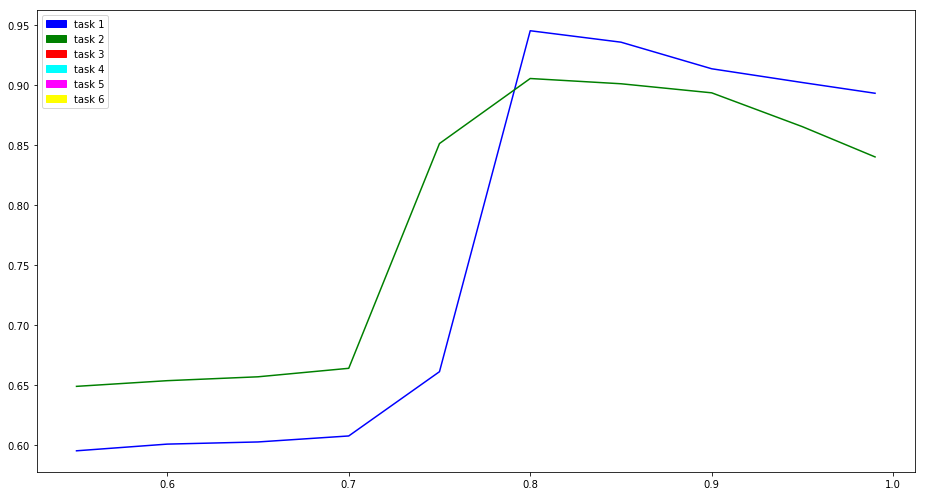

In [11]:
#LR PCA tuning cross-validation version
algorithms = [(LR(), 'Logistic Regression')]
csp_space = CSP(n_components=dataset_np.shape[1], reg='oas', transform_into='csp_space')
scaler = StandardScaler()
scaler_pow = StandardScaler()
fracs = np.array([0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99])
#au_global_scores = []
au_algorithm_scores = []
for frac in fracs:
    print('Started test with fraction', frac)
    transformer = PCA(n_components=frac, svd_solver='full')
    #au_algorithm_scores = []
    for alg, name in algorithms:
        print('    Started algorithm:', name)
        au_local_scores = []
        for i in range(target_matrix.shape[1]):
            print('        started task %i'%(i + 1))
            au_scores = []
            j = 1
            for train_idxs, test_idxs in cv.split(target_matrix[:, i]):
                print('            started fold %i'%(j))
                j += 1
                print('                started train transformation')
                train_matrix = scaler_pow.fit_transform(transformer.fit_transform(scaler.fit_transform(
                    TransformCSPWindowedDataset(csp_space.fit_transform(X=train_windowed[train_idxs],
                                                                        y=target_matrix[train_idxs, i])))))
                print('                started test transformation')
                test_matrix = scaler_pow.transform(transformer.transform(scaler.transform(
                    TransformCSPWindowedDataset(csp_space.transform(X=train_windowed[test_idxs])))))
                print('                started training')
                alg.fit(train_matrix, target_matrix[train_idxs, i])
                print('                started estimation')
                pred_score = alg.predict_proba(test_matrix)[:, 1].ravel()
                au_scores.append(roc_auc_score(y_true=target_matrix[test_idxs, i].ravel(), y_score=pred_score))
            au_local_scores.append(np.mean(au_scores))
        au_algorithm_scores.append(au_local_scores)
        print('                    Pipeline cross validation completed:', name, 'algorithm')
        print('                        mean auc roc is:', au_algorithm_scores[-1])
    #au_gobal_scores.append(au_algorithm_scores)
    print(au_algorithm_scores)
pca_tuning_scores = (('fractions', fracs), (('auc roc', np.array(au_algorithm_scores))))
file = open('LR_pca_tuning_results.pkl', 'wb')
pkl.dump(pca_tuning_scores, file)
file.close()

fig = plt.figure(figsize=(10, 8.5))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.57, right=1.79, wspace=0.0, hspace=0.0)

blue_patch = mpatches.Patch(color='blue', label='task 1')
green_patch = mpatches.Patch(color='green', label='task 2')
red_patch = mpatches.Patch(color='red', label='task 3')
cyan_patch = mpatches.Patch(color='cyan', label='task 4')
magneta_patch = mpatches.Patch(color='magenta', label='task 5')
yellow_patch = mpatches.Patch(color='yellow', label='task 6')

ax = plt.subplot(gs[0])
ax.legend(handles=[blue_patch, green_patch, red_patch, cyan_patch, magneta_patch, yellow_patch])

ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 0], color='blue')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 1], color='green')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 2], color='red')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 3], color='cyan')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 4], color='magenta')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 5], color='yellow')

ax.set_xlim([0.55, 0.99])
ax.set_ylim([0.0, 1.0])
plt.title('LR: dependence of scores from explained variance fraction', fontsize=20)
plt.xlabel('explained variance fraction', fontsize=14)
plt.ylabel('AUC ROC scores values', fontsize=14)

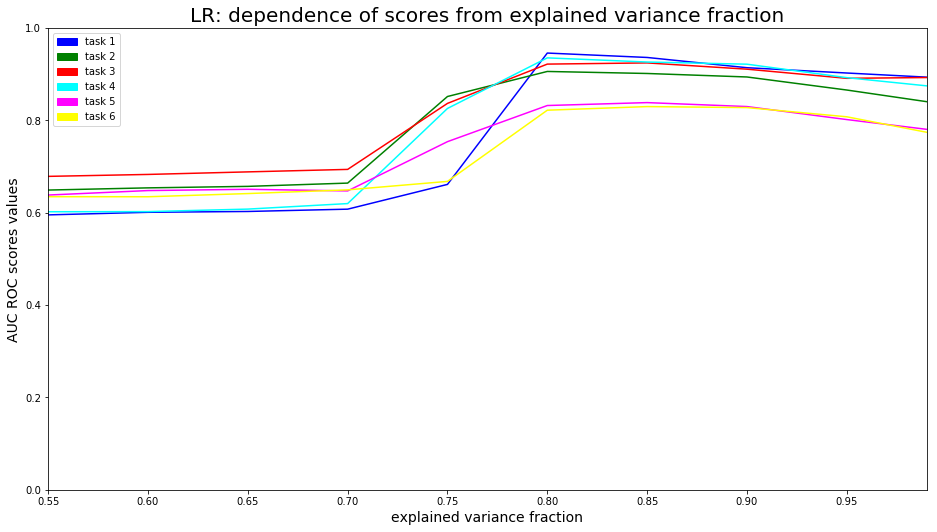

In [12]:
fig = plt.figure(figsize=(10, 8.5))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.57, right=1.79, wspace=0.0, hspace=0.0)

blue_patch = mpatches.Patch(color='blue', label='task 1')
green_patch = mpatches.Patch(color='green', label='task 2')
red_patch = mpatches.Patch(color='red', label='task 3')
cyan_patch = mpatches.Patch(color='cyan', label='task 4')
magneta_patch = mpatches.Patch(color='magenta', label='task 5')
yellow_patch = mpatches.Patch(color='yellow', label='task 6')

ax = plt.subplot(gs[0])
ax.legend(handles=[blue_patch, green_patch, red_patch, cyan_patch, magneta_patch, yellow_patch])

ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 0], color='blue')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 1], color='green')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 2], color='red')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 3], color='cyan')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 4], color='magenta')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][:, 5], color='yellow')

ax.set_xlim([0.55, 0.99])
ax.set_ylim([0.0, 1.0])
plt.title('LR: dependence of scores from explained variance fraction', fontsize=20)
plt.xlabel('explained variance fraction', fontsize=14)
plt.ylabel('AUC ROC scores values', fontsize=14)

Plot PCA tuning results

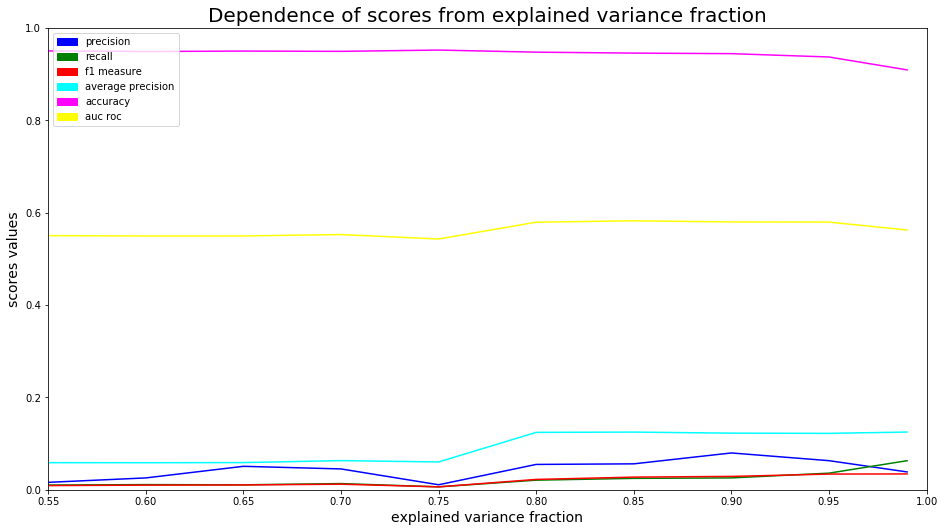

In [11]:
file = open('pca_tuning_results.pkl', 'rb')
pca_tuning_scores = pkl.load(file)
file.close()

fig = plt.figure(figsize=(10, 8.5))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.57, right=1.79, wspace=0.0, hspace=0.0)

blue_patch = mpatches.Patch(color='blue', label=pca_tuning_scores[1][0][0])
green_patch = mpatches.Patch(color='green', label=pca_tuning_scores[1][1][0])
red_patch = mpatches.Patch(color='red', label=pca_tuning_scores[1][2][0])
cyan_patch = mpatches.Patch(color='cyan', label=pca_tuning_scores[1][3][0])
magneta_patch = mpatches.Patch(color='magenta', label=pca_tuning_scores[1][4][0])
yellow_patch = mpatches.Patch(color='yellow', label=pca_tuning_scores[1][5][0])

ax = plt.subplot(gs[0])
ax.legend(handles=[blue_patch, green_patch, red_patch, cyan_patch, magneta_patch, yellow_patch])

ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][0][1], color='blue')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][1][1], color='green')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][2][1], color='red')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][3][1], color='cyan')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][4][1], color='magenta')
ax.plot(pca_tuning_scores[0][1], pca_tuning_scores[1][5][1], color='yellow')

ax.set_xlim([0.55, 1.0])
ax.set_ylim([0.0, 1.0])
plt.title('Dependence of scores from explained variance fraction', fontsize=20)
plt.xlabel('explained variance fraction', fontsize=14)
plt.ylabel('scores values', fontsize=14)

Selecting the number of components for CSP

In [12]:
#hold-out version
algorithms = [(SVC(probability=True), 'Support Vector Machine'),
              (LR(), 'Logistic Regression'),
              (KNC(), 'k Nearest Neighbors'),
              (DTC(), 'Decision Tree'),
              (RFC(), 'Random Forest'),
              (ETC(), 'Extra Trees'),
              (ABC(), 'Ada Boost'),
              (XGBC(), 'Extreme Gradient Boosting'),
              (LDA(), 'Linear Discriminant Analysis'),
              (QDA(), 'Quadratic Discriminant Analysis')]
scaler_pow = StandardScaler()
n_components_array = np.arange(1, dataset_np.shape[1] + 1)
pr_global_scores = []
rc_global_scores = []
f1_global_scores = []
ap_global_scores = []
ac_global_scores = []
au_global_scores = []
for n_components in n_components_array:
    print('Started test with the number of components', n_components)
    csp = CSP(n_components=dataset_np.shape[1], reg='oas')
    pr_algorithm_scores = []
    rc_algorithm_scores = []
    f1_algorithm_scores = []
    ap_algorithm_scores = []
    ac_algorithm_scores = []
    au_algorithm_scores = []
    for alg, name in algorithms:
        print('    Started algorithm:', name)
        pr_local_scores = []
        rc_local_scores = []
        f1_local_scores = []
        ap_local_scores = []
        ac_local_scores = []
        au_local_scores = []
        for i in range(target_matrix.shape[1]):
            print('        started task %i'%(i + 1))
            print('            started train transformation')
            train_matrix = scaler_pow.fit_transform(csp.fit_transform(X=dataset_np,
                                                               y=target_matrix[:, i]))
            print('            started test transformation')
            test_matrix = scaler_pow.transform(csp.transform(X=dataset_test))
            print('            started training')
            alg.fit(train_matrix, target_matrix[:, i])
            print('            started estimation')
            pred_score = alg.predict_proba(test_matrix)[:, 1].ravel()
            pred_label = alg.predict(test_matrix)
            pr_scores = precision_score(y_true=target_test_matrix[:, i].ravel(), y_pred=pred_label)
            rc_scores = recall_score(y_true=target_test_matrix[:, i].ravel(), y_pred=pred_label)
            f1_scores = f1_score(y_true=target_test_matrix[:, i].ravel(), y_pred=pred_label)
            ap_scores = average_precision_score(y_true=target_test_matrix[:, i].ravel(),
                                                     y_score=pred_score)
            ac_scores = accuracy_score(y_true=target_test_matrix[:, i].ravel(), y_pred=pred_label)
            au_scores = roc_auc_score(y_true=target_test_matrix[:, i].ravel(), y_score=pred_score)
            pr_local_scores.append(pr_scores)
            rc_local_scores.append(rc_scores)
            f1_local_scores.append(f1_scores)
            ap_local_scores.append(ap_scores)
            ac_local_scores.append(ac_scores)
            au_local_scores.append(au_scores)
        pr_algorithm_scores.append(np.mean(pr_local_scores))
        rc_algorithm_scores.append(np.mean(rc_local_scores))
        f1_algorithm_scores.append(np.mean(f1_local_scores))
        ap_algorithm_scores.append(np.mean(ap_local_scores))
        ac_algorithm_scores.append(np.mean(ac_local_scores))
        au_algorithm_scores.append(np.mean(au_local_scores))
        print('                    Pipeline cross validation completed:', name, 'algorithm')
        print('                        precision is:', pr_algorithm_scores[-1])
        print('                        recall is:', rc_algorithm_scores[-1])
        print('                        f1 measure is:', f1_algorithm_scores[-1])
        print('                        average precision is:', ap_algorithm_scores[-1])
        print('                        accuracy is:', ac_algorithm_scores[-1])
        print('                        auc roc is:', au_algorithm_scores[-1])
    pr_global_scores.append(np.mean(pr_algorithm_scores))
    rc_global_scores.append(np.mean(rc_algorithm_scores))
    f1_global_scores.append(np.mean(f1_algorithm_scores))
    ap_global_scores.append(np.mean(ap_algorithm_scores))
    ac_global_scores.append(np.mean(ac_algorithm_scores))
    au_global_scores.append(np.mean(au_algorithm_scores))
csp_tuning_scores = (('the number of components', n_components_array), (('precision', np.array(pr_global_scores)),
                                                                  ('recall', np.array(rc_global_scores)),
                                                                  ('f1 measure', np.array(f1_global_scores)),
                                                                  ('average precision', np.array(ap_global_scores)),
                                                                  ('accuracy', np.array(ac_global_scores)),
                                                                  ('auc roc', np.array(au_global_scores))))
file = open('csp_tuning_results.pkl', 'wb')
pkl.dump(csp_tuning_scores, file)
file.close()

Started test with the number of components %i 1
    Started algorithm: Support Vector Machine
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Support Vector Machine algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        averag

/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 2
            started train transformation
            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0606200649429
                        accuracy is: 0.956972361809
                        auc roc is: 0.54394234728
    Started algorithm: Extra Trees
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0751907473685
                        accuracy is: 0.957286432161
                        auc roc is: 0.546520379805
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0597931702283
                        accuracy is: 0.957181742044
                        auc roc is: 0.542032544645
    Started algorithm: Extra Trees
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0635150206462
                        accuracy is: 0.957286432161
                        auc roc is: 0.532636315681
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.166666666667
                        recall is: 0.00245098039216
                        f1 measure is: 0.0048309178744
                        average precision is: 0.0623120243964
                        accuracy is: 0.957391122278
                        auc roc is: 0.547732199835
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0678541380084
                        accuracy is: 0.957286432161
                        auc roc is: 0.558102227111
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816564492925
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794590474
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 6
            started train transformation
            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.061303436609
                        accuracy is: 0.956762981575
                        auc roc is: 0.547774818589
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0708723834092
                        accuracy is: 0.957286432161
                        auc roc is: 0.54676885518
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816564492925
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794590474
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0546556501286
                        accuracy is: 0.956972361809
                        auc roc is: 0.535996764191
    Started algorithm: Extra Trees
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0540922904395
                        accuracy is: 0.957286432161
                        auc roc is: 0.527718272348
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816564492925
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794590474
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0700327657466
                        accuracy is: 0.957077051926
                        auc roc is: 0.555884443672
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0616368847646
                        accuracy is: 0.957286432161
                        auc roc is: 0.544245503319
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816564492925
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794590474
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.166666666667
                        recall is: 0.00245098039216
                        f1 measure is: 0.0048309178744
                        average precision is: 0.0730785171635
                        accuracy is: 0.957391122278
                        auc roc is: 0.546193904071
    Started algorithm: Extra Trees
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0591094615165
                        accuracy is: 0.957286432161
                        auc roc is: 0.538881973393
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0731787379333
                        accuracy is: 0.956867671692
                        auc roc is: 0.567161526684
    Started algorithm: Extra Trees
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0619787245308
                        accuracy is: 0.957286432161
                        auc roc is: 0.536238002419
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816564492925
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794590474
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.00877192982456
                        recall is: 0.00245098039216
                        f1 measure is: 0.00383141762452
                        average precision is: 0.0620522798318
                        accuracy is: 0.95540201005
                        auc roc is: 0.551990858679
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0644361818171
                        accuracy is: 0.957286432161
                        auc roc is: 0.538727580927
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0715310353478
                        accuracy is: 0.957286432161
                        auc roc is: 0.545692128557
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0655533825044
                        accuracy is: 0.957286432161
                        auc roc is: 0.536738973805
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0598406116056
                        accuracy is: 0.955087939698
                        auc roc is: 0.54800560316
    Started algorithm: Extra Trees
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0749635551115
                        accuracy is: 0.957286432161
                        auc roc is: 0.560982611549
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0713516965554
                        accuracy is: 0.957181742044
                        auc roc is: 0.567700292059
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0750900832339
                        accuracy is: 0.957286432161
                        auc roc is: 0.574073806032
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816564492925
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794590474
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0582261519711
                        accuracy is: 0.957286432161
                        auc roc is: 0.536251672585
    Started algorithm: Extra Trees
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.065970561125
                        accuracy is: 0.957286432161
                        auc roc is: 0.538694611703
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.166666666667
                        recall is: 0.00245098039216
                        f1 measure is: 0.0048309178744
                        average precision is: 0.0603581703793
                        accuracy is: 0.957286432161
                        auc roc is: 0.547868901498
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0637237730944
                        accuracy is: 0.957286432161
                        auc roc is: 0.544901671298
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0598185390657
                        accuracy is: 0.956762981575
                        auc roc is: 0.552319746796
    Started algorithm: Extra Trees
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.06141182894
                        accuracy is: 0.957286432161
                        auc roc is: 0.528384089856
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0592344152474
                        accuracy is: 0.957181742044
                        auc roc is: 0.542357412125
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0653491820272
                        accuracy is: 0.957286432161
                        auc roc is: 0.556196445113
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0277777777778
                        recall is: 0.00245098039216
                        f1 measure is: 0.0045045045045
                        average precision is: 0.055275651246
                        accuracy is: 0.956867671692
                        auc roc is: 0.529680343266
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0757910941297
                        accuracy is: 0.957286432161
                        auc roc is: 0.526411565282
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0638300415061
                        accuracy is: 0.956658291457
                        auc roc is: 0.553303194637
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0647185626764
                        accuracy is: 0.957286432161
                        auc roc is: 0.548131851166
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816564492925
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794590474
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 6
            started train transformation
            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0833333333333
                        recall is: 0.00245098039216
                        f1 measure is: 0.0047619047619
                        average precision is: 0.0640350255855
                        accuracy is: 0.957286432161
                        auc roc is: 0.547361497092
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0699920853427
                        accuracy is: 0.957286432161
                        auc roc is: 0.56481427873
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816564492925
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794590474
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0696649143152
                        accuracy is: 0.957181742044
                        auc roc is: 0.545512808142
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.072431827295
                        accuracy is: 0.957286432161
                        auc roc is: 0.548931153826
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.166666666667
                        recall is: 0.00245098039216
                        f1 measure is: 0.0048309178744
                        average precision is: 0.0758042827492
                        accuracy is: 0.957391122278
                        auc roc is: 0.536157589676
    Started algorithm: Extra Trees
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0633614614357
                        accuracy is: 0.957286432161
                        auc roc is: 0.534306488343
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 6
            started train transformation
            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0545375663604
                        accuracy is: 0.956134840871
                        auc roc is: 0.543830573568
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0618801988645
                        accuracy is: 0.957286432161
                        auc roc is: 0.539247047244
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816564492925
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794590474
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.063731622017
                        accuracy is: 0.957286432161
                        auc roc is: 0.55389262004
    Started algorithm: Extra Trees
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0786173618483
                        accuracy is: 0.957286432161
                        auc roc is: 0.540264268437
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0640304331267
                        accuracy is: 0.957077051926
                        auc roc is: 0.561194097061
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0668581197284
                        accuracy is: 0.957286432161
                        auc roc is: 0.537555967269
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0833333333333
                        recall is: 0.00245098039216
                        f1 measure is: 0.0047619047619
                        average precision is: 0.0648783564319
                        accuracy is: 0.957181742044
                        auc roc is: 0.539789833256
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0659335119135
                        accuracy is: 0.957286432161
                        auc roc is: 0.553132719623
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0611488261091
                        accuracy is: 0.957181742044
                        auc roc is: 0.540336639905
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0691771916885
                        accuracy is: 0.957286432161
                        auc roc is: 0.538556301786
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816564492925
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794590474
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0833333333333
                        recall is: 0.00245098039216
                        f1 measure is: 0.0047619047619
                        average precision is: 0.0752059898382
                        accuracy is: 0.957181742044
                        auc roc is: 0.577327305594
    Started algorithm: Extra Trees
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.064281757057
                        accuracy is: 0.957286432161
                        auc roc is: 0.543631149967
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816564492925
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794590474
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0576429718544
                        accuracy is: 0.954878559464
                        auc roc is: 0.546029862076
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0868187643638
                        accuracy is: 0.957286432161
                        auc roc is: 0.579453418507
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0713361822575
                        accuracy is: 0.957181742044
                        auc roc is: 0.551330670063
    Started algorithm: Extra Trees
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0733602363614
                        accuracy is: 0.957286432161
                        auc roc is: 0.547095330915
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816564492925
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794590474
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.166666666667
                        recall is: 0.00245098039216
                        f1 measure is: 0.0048309178744
                        average precision is: 0.0594453689091
                        accuracy is: 0.957286432161
                        auc roc is: 0.545714644125
    Started algorithm: Extra Trees
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0696301439996
                        accuracy is: 0.957286432161
                        auc roc is: 0.555939124337
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816564492925
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794590474
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.069789475633
                        accuracy is: 0.957286432161
                        auc roc is: 0.553726165663
    Started algorithm: Extra Trees
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0598739157254
                        accuracy is: 0.957286432161
                        auc roc is: 0.546189883434
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816554518919
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794268823
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Random Forest algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0539950193647
                        accuracy is: 0.955820770519
                        auc roc is: 0.541295963924
    Started algorithm: Extra Trees
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extra Trees algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0755105786743
                        accuracy is: 0.957286432161
                        auc roc is: 0.547334960887
    Started algorithm: Ada Boost
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Ada Boost algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0816564492925
                        accuracy is: 0.956972361809
                        auc roc is: 0.65794590474
    Started algorithm: Extreme Gradient Boosting
        started task 1
            started train transformation
            started test transformation
            started training
            started estimation
        started task 2
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 3
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 4
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 5
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 6
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Extreme Gradient Boosting algorithm
                        precision is: 0.0
                        recall is: 0.0
                        f1 measure is: 0.0
                        average precision is: 0.0801585189197
                        accuracy is: 0.957286432161
                        auc roc is: 0.667071142762
    Started algorithm: Linear Discriminant Analysis
        started task 1
            started train transformation


/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yudin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            started test transformation
            started training
            started estimation
        started task 2
            started train transformation
            started test transformation
            started training
            started estimation
        started task 3
            started train transformation
            started test transformation
            started training
            started estimation
        started task 4
            started train transformation
            started test transformation
            started training
            started estimation
        started task 5
            started train transformation
            started test transformation
            started training
            started estimation
        started task 6
            started train transformation
            started test transformation
            started training
            started estimation
                    Pipeline cross validation completed: Linear Discriminant Ana

In [ ]:
#cross-validation version
algorithms = [(SVC(probability=True), 'Support Vector Machine'),
              (LR(), 'Logistic Regression'),
              (KNC(), 'k Nearest Neighbors'),
              (DTC(), 'Decision Tree'),
              (RFC(), 'Random Forest'),
              (ETC(), 'Extra Trees'),
              (ABC(), 'Ada Boost'),
              (XGBC(), 'Extreme Gradient Boosting'),
              (LDA(), 'Linear Discriminant Analysis'),
              (QDA(), 'Quadratic Discriminant Analysis')]
scaler_pow = StandardScaler()
n_components_array = np.arange(1, dataset_np.shape[1] + 1)
pr_global_scores = []
rc_global_scores = []
f1_global_scores = []
ap_global_scores = []
ac_global_scores = []
au_global_scores = []
for n_components in n_components_array:
    print('Started test with the number of components %i', n_components)
    csp = CSP(n_components=dataset_np.shape[1], reg='oas')
    pr_algorithm_scores = []
    rc_algorithm_scores = []
    f1_algorithm_scores = []
    ap_algorithm_scores = []
    ac_algorithm_scores = []
    au_algorithm_scores = []
    for alg, name in algorithms:
        print('    Started algorithm:', name)
        pr_local_scores = []
        rc_local_scores = []
        f1_local_scores = []
        ap_local_scores = []
        ac_local_scores = []
        au_local_scores = []
        for i in range(target_matrix.shape[1]):
            print('        started task %i'%(i + 1))
            pr_scores = []
            rc_scores = []
            f1_scores = []
            ap_scores = []
            ac_scores = []
            au_scores = []
            j = 1
            for train_idxs, test_idxs in cv.split(target_matrix[:, i]):
                print('            started fold %i'%(j))
                j += 1
                print('                started train transformation')
                train_matrix = scaler_pow.fit_transform(csp.fit_transform(X=dataset_np[train_idxs],
                                                                      y=target_matrix[train_idxs, i]))
                print('                started test transformation')
                test_matrix = scaler_pow.transform(csp.transform(X=dataset_np[test_idxs]))
                print('                started training')
                alg.fit(train_matrix, target_matrix[train_idxs, i])
                print('                started estimation')
                pred_score = alg.predict_proba(test_matrix)[:, 1].ravel()
                pred_label = alg.predict(test_matrix)
                pr_scores.append(precision_score(y_true=target_matrix[test_idxs, i].ravel(), y_pred=pred_label))
                rc_scores.append(recall_score(y_true=target_matrix[test_idxs, i].ravel(), y_pred=pred_label))
                f1_scores.append(f1_score(y_true=target_matrix[test_idxs, i].ravel(), y_pred=pred_label))
                ap_scores.append(average_precision_score(y_true=target_matrix[test_idxs, i].ravel(),
                                                         y_score=pred_score))
                ac_scores.append(accuracy_score(y_true=target_matrix[test_idxs, i].ravel(), y_pred=pred_label))
                au_scores.append(roc_auc_score(y_true=target_matrix[test_idxs, i].ravel(), y_score=pred_score))
            pr_local_scores.append(np.mean(pr_scores))
            rc_local_scores.append(np.mean(rc_scores))
            f1_local_scores.append(np.mean(f1_scores))
            ap_local_scores.append(np.mean(ap_scores))
            ac_local_scores.append(np.mean(ac_scores))
            au_local_scores.append(np.mean(au_scores))
        pr_algorithm_scores.append(np.mean(pr_local_scores))
        rc_algorithm_scores.append(np.mean(rc_local_scores))
        f1_algorithm_scores.append(np.mean(f1_local_scores))
        ap_algorithm_scores.append(np.mean(ap_local_scores))
        ac_algorithm_scores.append(np.mean(ac_local_scores))
        au_algorithm_scores.append(np.mean(au_local_scores))
        print('                    Pipeline cross validation completed:', name, 'algorithm')
        print('                        mean precision is:', pr_algorithm_scores[-1])
        print('                        mean recall is:', rc_algorithm_scores[-1])
        print('                        mean f1 measure is:', f1_algorithm_scores[-1])
        print('                        mean average precision is:', ap_algorithm_scores[-1])
        print('                        mean accuracy is:', ac_algorithm_scores[-1])
        print('                        mean auc roc is:', au_algorithm_scores[-1])
    pr_global_scores.append(np.mean(pr_algorithm_scores))
    rc_global_scores.append(np.mean(rc_algorithm_scores))
    f1_global_scores.append(np.mean(f1_algorithm_scores))
    ap_global_scores.append(np.mean(ap_algorithm_scores))
    ac_global_scores.append(np.mean(ac_algorithm_scores))
    au_global_scores.append(np.mean(au_algorithm_scores))
csp_tuning_scores = (('the number of components', n_components_array), (('precision', np.array(pr_global_scores)),
                                                                  ('recall', np.array(rc_global_scores)),
                                                                  ('f1 measure', np.array(f1_global_scores)),
                                                                  ('average precision', np.array(ap_global_scores)),
                                                                  ('accuracy', np.array(ac_global_scores)),
                                                                  ('auc roc', np.array(au_global_scores))))
file = open('csp_tuning_results.pkl', 'wb')
pkl.dump(csp_tuning_scores, file)
file.close()

n_components = 1
n_components = 2
n_components = 3
n_components = 4
n_components = 5
n_components = 6
n_components = 7
n_components = 8
n_components = 9
n_components = 10
n_components = 11
n_components = 12
n_components = 13
n_components = 14
n_components = 15
n_components = 16
n_components = 17
n_components = 18
n_components = 19
n_components = 20
n_components = 21
n_components = 22
n_components = 23
n_components = 24
n_components = 25
n_components = 26
n_components = 27
n_components = 28
n_components = 29
n_components = 30
n_components = 31
n_components = 32


TypeError: string indices must be integers

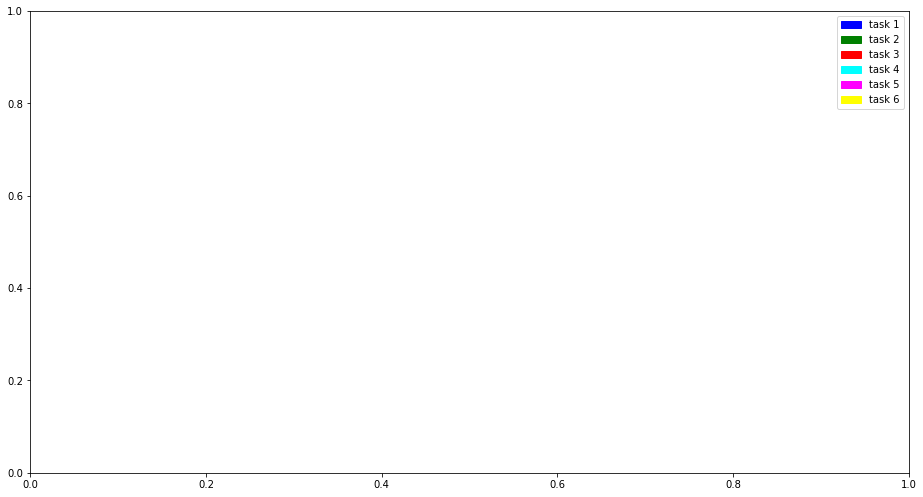

In [13]:
#SVC cross-val tuning version
mean_auc_oas = []
mean_target_auc_oas = []
for j in range(1, 33):
    clf_oas = Pipeline([('CSP', CSP(n_components=j, reg='oas')), ('SVC', SVC(probability=True))])
    print('n_components =', j)
    local_scores_oas = []
    for i in range(target_matrix.shape[1]):
        scores_oas = cross_val_score(clf_oas, train_windowed, target_matrix[:, i], scoring='roc_auc',
                                 cv=cv.split(target_matrix),
                                 n_jobs=3)
        local_scores_oas.append(np.mean(scores_oas))
        #print('    Pipeline cross validation completed (channel %i):'%(i))
        #print('        mean roc auc is:', local_scores[-1])
    mean_target_auc_oas.append(local_scores_oas)
    mean_auc_oas.append(np.mean(local_scores_oas))
mean_target_auc_oas = np.array(mean_target_auc_oas)

csp_tuning_scores = (('the number of components', np.arange(1, 33)),
                     (('mean auc roc (oas reg)', mean_target_auc_oas)))

file = open('SVC_csp_tuning_results.pkl', 'wb')
pkl.dump(csp_tuning_scores, file)
file.close()

fig = plt.figure(figsize=(10, 8.5))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.57, right=1.79, wspace=0.0, hspace=0.0)

blue_patch = mpatches.Patch(color='blue', label='task 1')
green_patch = mpatches.Patch(color='green', label='task 2')
red_patch = mpatches.Patch(color='red', label='task 3')
cyan_patch = mpatches.Patch(color='cyan', label='task 4')
magneta_patch = mpatches.Patch(color='magenta', label='task 5')
yellow_patch = mpatches.Patch(color='yellow', label='task 6')

ax = plt.subplot(gs[0])
ax.legend(handles=[blue_patch, green_patch, red_patch, cyan_patch, magneta_patch, yellow_patch])

ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 0], color='blue')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 1], color='green')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 2], color='red')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 3], color='cyan')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 4], color='magenta')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 5], color='yellow')

ax.set_xlim([1.0, 32.0])
ax.set_ylim([0.0, 1.0])
plt.title('SVC: dependence of scores from the number of components', fontsize=20)
plt.xlabel('the number of components', fontsize=14)
plt.ylabel('AUC ROC score values', fontsize=14)

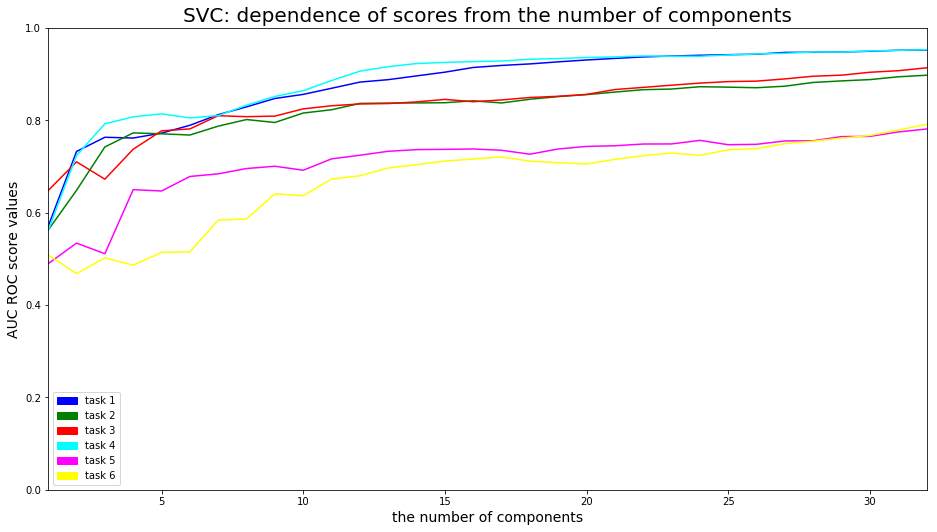

In [18]:
fig = plt.figure(figsize=(10, 8.5))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.57, right=1.79, wspace=0.0, hspace=0.0)

blue_patch = mpatches.Patch(color='blue', label='task 1')
green_patch = mpatches.Patch(color='green', label='task 2')
red_patch = mpatches.Patch(color='red', label='task 3')
cyan_patch = mpatches.Patch(color='cyan', label='task 4')
magneta_patch = mpatches.Patch(color='magenta', label='task 5')
yellow_patch = mpatches.Patch(color='yellow', label='task 6')

ax = plt.subplot(gs[0])
ax.legend(handles=[blue_patch, green_patch, red_patch, cyan_patch, magneta_patch, yellow_patch])

ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 0], color='blue')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 1], color='green')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 2], color='red')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 3], color='cyan')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 4], color='magenta')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 5], color='yellow')

ax.set_xlim([1.0, 32.0])
ax.set_ylim([0.0, 1.0])
plt.title('SVC: dependence of scores from the number of components', fontsize=20)
plt.xlabel('the number of components', fontsize=14)
plt.ylabel('AUC ROC score values', fontsize=14)

n_components = 1
n_components = 2
n_components = 3
n_components = 4
n_components = 5
n_components = 6
n_components = 7
n_components = 8
n_components = 9
n_components = 10
n_components = 11
n_components = 12
n_components = 13
n_components = 14
n_components = 15
n_components = 16
n_components = 17
n_components = 18
n_components = 19
n_components = 20
n_components = 21
n_components = 22
n_components = 23
n_components = 24
n_components = 25
n_components = 26
n_components = 27
n_components = 28
n_components = 29
n_components = 30
n_components = 31
n_components = 32


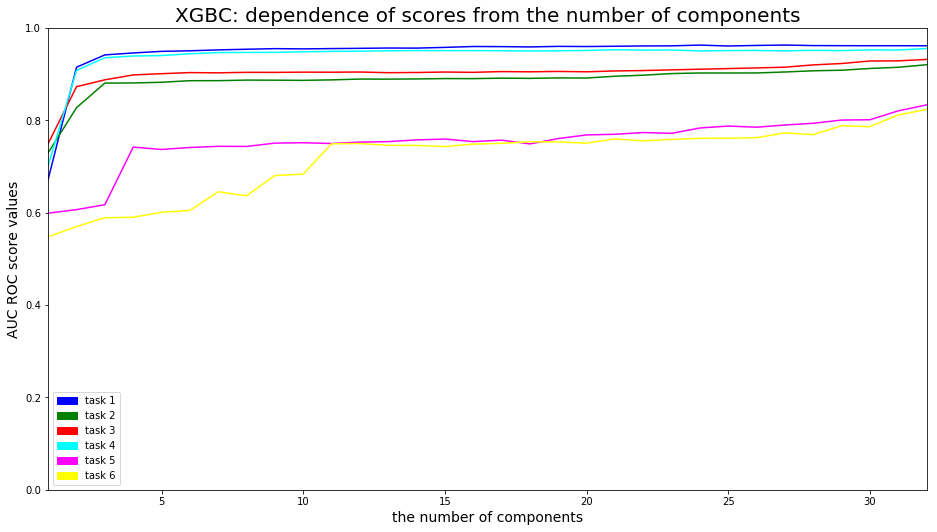

In [19]:
#XGBC cross-val tuning version
mean_auc_oas = []
mean_target_auc_oas = []
for j in range(1, 33):
    clf_oas = Pipeline([('CSP', CSP(n_components=j, reg='oas')), ('XGBC', XGBC())])
    print('n_components =', j)
    local_scores_oas = []
    for i in range(target_matrix.shape[1]):
        scores_oas = cross_val_score(clf_oas, train_windowed, target_matrix[:, i], scoring='roc_auc',
                                 cv=cv.split(target_matrix),
                                 n_jobs=3)
        local_scores_oas.append(np.mean(scores_oas))
        #print('    Pipeline cross validation completed (channel %i):'%(i))
        #print('        mean roc auc is:', local_scores[-1])
    mean_target_auc_oas.append(local_scores_oas)
    mean_auc_oas.append(np.mean(local_scores_oas))
mean_target_auc_oas = np.array(mean_target_auc_oas)

csp_tuning_scores = (('the number of components', np.arange(1, 33)),
                     (('mean auc roc (oas reg)', mean_target_auc_oas)))

file = open('XGBC_csp_tuning_results.pkl', 'wb')
pkl.dump(csp_tuning_scores, file)
file.close()

fig = plt.figure(figsize=(10, 8.5))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.57, right=1.79, wspace=0.0, hspace=0.0)

blue_patch = mpatches.Patch(color='blue', label='task 1')
green_patch = mpatches.Patch(color='green', label='task 2')
red_patch = mpatches.Patch(color='red', label='task 3')
cyan_patch = mpatches.Patch(color='cyan', label='task 4')
magneta_patch = mpatches.Patch(color='magenta', label='task 5')
yellow_patch = mpatches.Patch(color='yellow', label='task 6')

ax = plt.subplot(gs[0])
ax.legend(handles=[blue_patch, green_patch, red_patch, cyan_patch, magneta_patch, yellow_patch])

ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 0], color='blue')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 1], color='green')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 2], color='red')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 3], color='cyan')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 4], color='magenta')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 5], color='yellow')

ax.set_xlim([1.0, 32.0])
ax.set_ylim([0.0, 1.0])
plt.title('XGBC: dependence of scores from the number of components', fontsize=20)
plt.xlabel('the number of components', fontsize=14)
plt.ylabel('AUC ROC score values', fontsize=14)

n_components = 1
n_components = 2
n_components = 3
n_components = 4
n_components = 5
n_components = 6
n_components = 7
n_components = 8
n_components = 9
n_components = 10
n_components = 11
n_components = 12
n_components = 13
n_components = 14
n_components = 15
n_components = 16
n_components = 17
n_components = 18
n_components = 19
n_components = 20
n_components = 21
n_components = 22
n_components = 23
n_components = 24
n_components = 25
n_components = 26
n_components = 27
n_components = 28
n_components = 29
n_components = 30
n_components = 31
n_components = 32


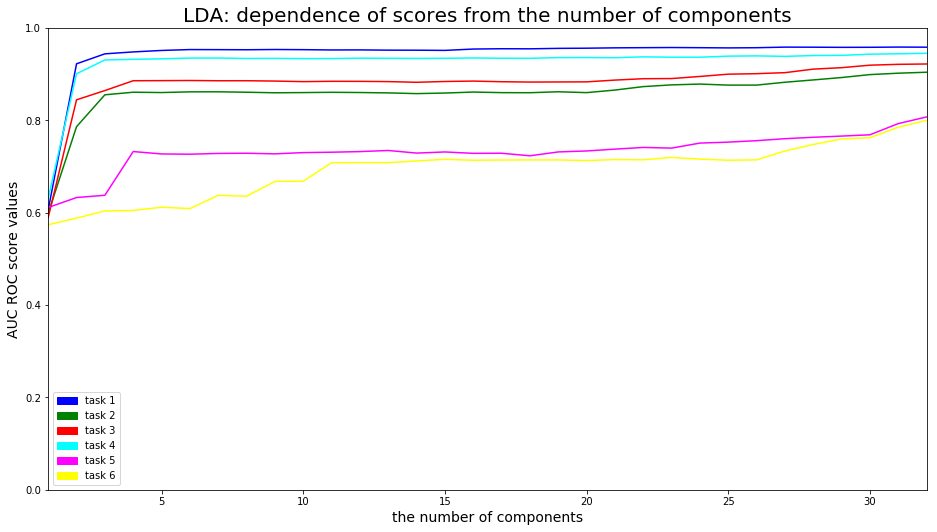

In [20]:
#LDA cross-val tuning version
mean_auc_oas = []
mean_target_auc_oas = []
for j in range(1, 33):
    clf_oas = Pipeline([('CSP', CSP(n_components=j, reg='oas')), ('LDA', LDA())])
    print('n_components =', j)
    local_scores_oas = []
    for i in range(target_matrix.shape[1]):
        scores_oas = cross_val_score(clf_oas, train_windowed, target_matrix[:, i], scoring='roc_auc',
                                 cv=cv.split(target_matrix),
                                 n_jobs=3)
        local_scores_oas.append(np.mean(scores_oas))
        #print('    Pipeline cross validation completed (channel %i):'%(i))
        #print('        mean roc auc is:', local_scores[-1])
    mean_target_auc_oas.append(local_scores_oas)
    mean_auc_oas.append(np.mean(local_scores_oas))
mean_target_auc_oas = np.array(mean_target_auc_oas)

csp_tuning_scores = (('the number of components', np.arange(1, 33)),
                     (('mean auc roc (oas reg)', mean_target_auc_oas)))

file = open('LDA_csp_tuning_results.pkl', 'wb')
pkl.dump(csp_tuning_scores, file)
file.close()

fig = plt.figure(figsize=(10, 8.5))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.57, right=1.79, wspace=0.0, hspace=0.0)

blue_patch = mpatches.Patch(color='blue', label='task 1')
green_patch = mpatches.Patch(color='green', label='task 2')
red_patch = mpatches.Patch(color='red', label='task 3')
cyan_patch = mpatches.Patch(color='cyan', label='task 4')
magneta_patch = mpatches.Patch(color='magenta', label='task 5')
yellow_patch = mpatches.Patch(color='yellow', label='task 6')

ax = plt.subplot(gs[0])
ax.legend(handles=[blue_patch, green_patch, red_patch, cyan_patch, magneta_patch, yellow_patch])

ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 0], color='blue')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 1], color='green')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 2], color='red')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 3], color='cyan')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 4], color='magenta')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 5], color='yellow')

ax.set_xlim([1.0, 32.0])
ax.set_ylim([0.0, 1.0])
plt.title('LDA: dependence of scores from the number of components', fontsize=20)
plt.xlabel('the number of components', fontsize=14)
plt.ylabel('AUC ROC score values', fontsize=14)

n_components = 1
n_components = 2
n_components = 3
n_components = 4
n_components = 5
n_components = 6
n_components = 7
n_components = 8
n_components = 9
n_components = 10
n_components = 11
n_components = 12
n_components = 13
n_components = 14
n_components = 15
n_components = 16
n_components = 17
n_components = 18
n_components = 19
n_components = 20
n_components = 21
n_components = 22
n_components = 23
n_components = 24
n_components = 25
n_components = 26
n_components = 27
n_components = 28
n_components = 29
n_components = 30
n_components = 31
n_components = 32


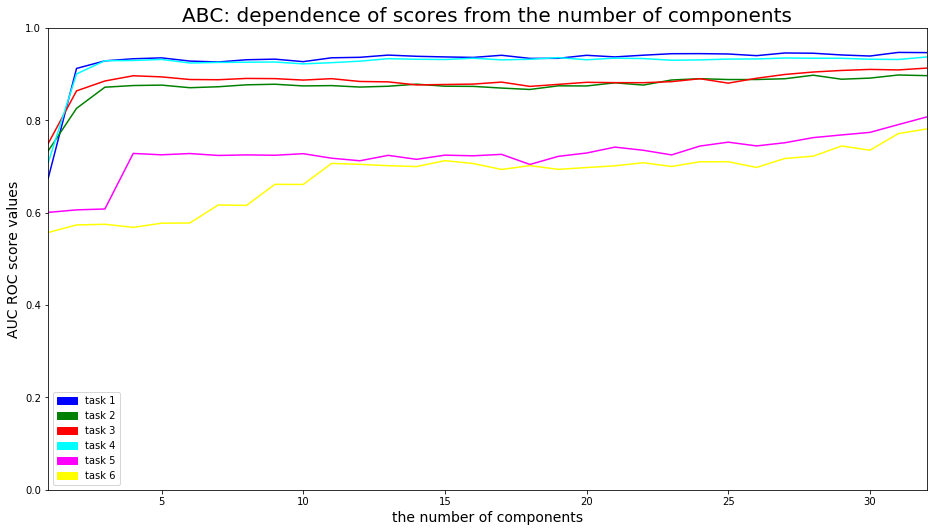

In [21]:
#ABC cross-val tuning version
mean_auc_oas = []
mean_target_auc_oas = []
for j in range(1, 33):
    clf_oas = Pipeline([('CSP', CSP(n_components=j, reg='oas')), ('ABC', ABC())])
    print('n_components =', j)
    local_scores_oas = []
    for i in range(target_matrix.shape[1]):
        scores_oas = cross_val_score(clf_oas, train_windowed, target_matrix[:, i], scoring='roc_auc',
                                 cv=cv.split(target_matrix),
                                 n_jobs=3)
        local_scores_oas.append(np.mean(scores_oas))
        #print('    Pipeline cross validation completed (channel %i):'%(i))
        #print('        mean roc auc is:', local_scores[-1])
    mean_target_auc_oas.append(local_scores_oas)
    mean_auc_oas.append(np.mean(local_scores_oas))
mean_target_auc_oas = np.array(mean_target_auc_oas)

csp_tuning_scores = (('the number of components', np.arange(1, 33)),
                     (('mean auc roc (oas reg)', mean_target_auc_oas)))

file = open('ABC_csp_tuning_results.pkl', 'wb')
pkl.dump(csp_tuning_scores, file)
file.close()

fig = plt.figure(figsize=(10, 8.5))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.57, right=1.79, wspace=0.0, hspace=0.0)

blue_patch = mpatches.Patch(color='blue', label='task 1')
green_patch = mpatches.Patch(color='green', label='task 2')
red_patch = mpatches.Patch(color='red', label='task 3')
cyan_patch = mpatches.Patch(color='cyan', label='task 4')
magneta_patch = mpatches.Patch(color='magenta', label='task 5')
yellow_patch = mpatches.Patch(color='yellow', label='task 6')

ax = plt.subplot(gs[0])
ax.legend(handles=[blue_patch, green_patch, red_patch, cyan_patch, magneta_patch, yellow_patch])

ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 0], color='blue')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 1], color='green')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 2], color='red')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 3], color='cyan')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 4], color='magenta')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 5], color='yellow')

ax.set_xlim([1.0, 32.0])
ax.set_ylim([0.0, 1.0])
plt.title('ABC: dependence of scores from the number of components', fontsize=20)
plt.xlabel('the number of components', fontsize=14)
plt.ylabel('AUC ROC score values', fontsize=14)

n_components = 1
n_components = 2
n_components = 3
n_components = 4
n_components = 5
n_components = 6
n_components = 7
n_components = 8
n_components = 9
n_components = 10
n_components = 11
n_components = 12
n_components = 13
n_components = 14
n_components = 15
n_components = 16
n_components = 17
n_components = 18
n_components = 19
n_components = 20
n_components = 21
n_components = 22
n_components = 23
n_components = 24
n_components = 25
n_components = 26
n_components = 27
n_components = 28
n_components = 29
n_components = 30
n_components = 31
n_components = 32


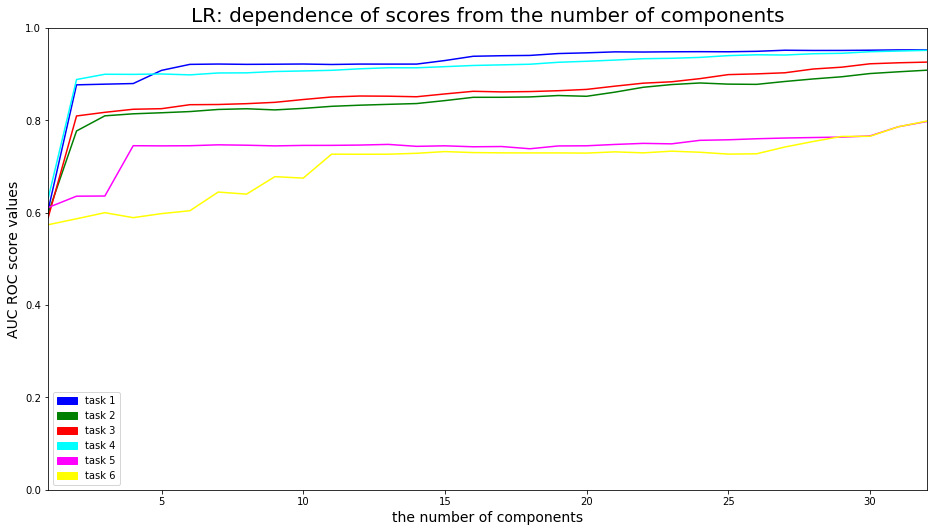

In [22]:
#LR cross-val tuning version
mean_auc_oas = []
mean_target_auc_oas = []
for j in range(1, 33):
    clf_oas = Pipeline([('CSP', CSP(n_components=j, reg='oas')), ('LR', LR())])
    print('n_components =', j)
    local_scores_oas = []
    for i in range(target_matrix.shape[1]):
        scores_oas = cross_val_score(clf_oas, train_windowed, target_matrix[:, i], scoring='roc_auc',
                                 cv=cv.split(target_matrix),
                                 n_jobs=3)
        local_scores_oas.append(np.mean(scores_oas))
        #print('    Pipeline cross validation completed (channel %i):'%(i))
        #print('        mean roc auc is:', local_scores[-1])
    mean_target_auc_oas.append(local_scores_oas)
    mean_auc_oas.append(np.mean(local_scores_oas))
mean_target_auc_oas = np.array(mean_target_auc_oas)

csp_tuning_scores = (('the number of components', np.arange(1, 33)),
                     (('mean auc roc (oas reg)', mean_target_auc_oas)))

file = open('LR_csp_tuning_results.pkl', 'wb')
pkl.dump(csp_tuning_scores, file)
file.close()

fig = plt.figure(figsize=(10, 8.5))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.57, right=1.79, wspace=0.0, hspace=0.0)

blue_patch = mpatches.Patch(color='blue', label='task 1')
green_patch = mpatches.Patch(color='green', label='task 2')
red_patch = mpatches.Patch(color='red', label='task 3')
cyan_patch = mpatches.Patch(color='cyan', label='task 4')
magneta_patch = mpatches.Patch(color='magenta', label='task 5')
yellow_patch = mpatches.Patch(color='yellow', label='task 6')

ax = plt.subplot(gs[0])
ax.legend(handles=[blue_patch, green_patch, red_patch, cyan_patch, magneta_patch, yellow_patch])

ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 0], color='blue')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 1], color='green')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 2], color='red')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 3], color='cyan')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 4], color='magenta')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][:, 5], color='yellow')

ax.set_xlim([1.0, 32.0])
ax.set_ylim([0.0, 1.0])
plt.title('LR: dependence of scores from the number of components', fontsize=20)
plt.xlabel('the number of components', fontsize=14)
plt.ylabel('AUC ROC score values', fontsize=14)

Plot CSP tuning results

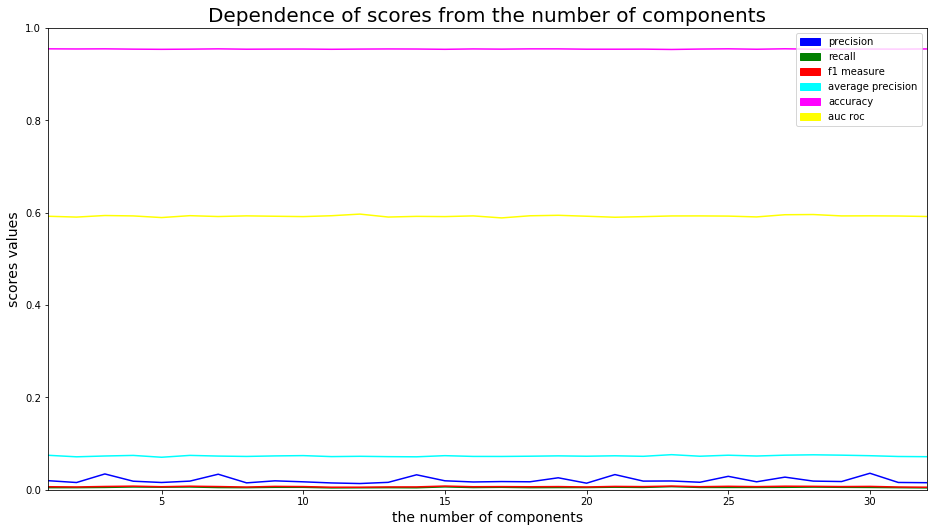

In [13]:
file = open('csp_tuning_results.pkl', 'rb')
csp_tuning_scores = pkl.load(file)
file.close()

fig = plt.figure(figsize=(10, 8.5))
gs = gridspec.GridSpec(1, 1)
gs.update(left=0.57, right=1.79, wspace=0.0, hspace=0.0)

blue_patch = mpatches.Patch(color='blue', label=csp_tuning_scores[1][0][0])
green_patch = mpatches.Patch(color='green', label=csp_tuning_scores[1][1][0])
red_patch = mpatches.Patch(color='red', label=csp_tuning_scores[1][2][0])
cyan_patch = mpatches.Patch(color='cyan', label=csp_tuning_scores[1][3][0])
magneta_patch = mpatches.Patch(color='magenta', label=csp_tuning_scores[1][4][0])
yellow_patch = mpatches.Patch(color='yellow', label=csp_tuning_scores[1][5][0])

ax = plt.subplot(gs[0])
ax.legend(handles=[blue_patch, green_patch, red_patch, cyan_patch, magneta_patch, yellow_patch])

ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][0][1], color='blue')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][1][1], color='green')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][2][1], color='red')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][3][1], color='cyan')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][4][1], color='magenta')
ax.plot(csp_tuning_scores[0][1], csp_tuning_scores[1][5][1], color='yellow')

ax.set_xlim([1.0, 32.0])
ax.set_ylim([0.0, 1.0])
plt.title('Dependence of scores from the number of components', fontsize=20)
plt.xlabel('the number of components', fontsize=14)
plt.ylabel('scores values', fontsize=14)